In [1]:
# ==============================================================================
# GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
import sys

# Scikit-learn kütüphaneleri
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_recall_fscore_support, roc_curve, auc, roc_auc_score)
from sklearn.dummy import DummyClassifier

# Sınıf dengesizliği için
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost kütüphanesi yüklü değil")

# Ayarlar
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("="*80)
print("TRAFİK KAZASI ŞİDDETİ TAHMİN PROJESİ")
print("="*80)

TRAFİK KAZASI ŞİDDETİ TAHMİN PROJESİ


In [2]:
# ==============================================================================
# AŞAMA 1: VERİ YÜKLEME VE İLK BAKIŞ - DÜZELTİLMİŞ
# ==============================================================================
print("\n" + "="*60)
print("AŞAMA 1: VERİ YÜKLEME VE İLK BAKIŞ")
print("="*60)

try:
    df = pd.read_csv('usacc.csv')
    print("✓ Veri seti başarıyla yüklendi.")
    print(f"✓ Orijinal veri boyutu: {df.shape}")
    print(f"✓ Sütun sayısı: {len(df.columns)}")
except FileNotFoundError:
    print("✗ HATA: 'usacc.csv' dosyası bulunamadı.")
    exit()
except MemoryError:
    print("✗ HATA: Bellek yetersiz! CSV'yi parçalar halinde okuyun.")
    exit()

# Hedef değişkeni kontrol et
print(f"\n✓ Hedef değişken 'Severity' değerleri: {df['Severity'].unique()}")
print(f"✓ Severity dağılımı:")
severity_orig_counts = df['Severity'].value_counts().sort_index()
for severity, count in severity_orig_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  - Severity {severity}: {count:,} ({percentage:.2f}%)")

# Büyük veri için örneklem al - DÜZELTİLMİŞ
import numpy as np

if len(df) > 2000000:
    try:
        # Daha verimli örneklem alma
        sample_size = min(2000000, int(len(df) * 0.5))  # Maksimum 2M veya %50
        print(f"\n✓ {sample_size:,} örneklem alınıyor...")
        
        # Bellek dostu örneklem alma
        df_sample = df.sample(n=sample_size, random_state=42, replace=False)
        
        # Orijinal DataFrame'i bellekten temizle
        del df
        import gc
        gc.collect()
        
        print(f"✓ Örneklem alındı. Yeni boyut: {df_sample.shape}")
    except Exception as e:
        print(f"✗ Örneklem alma hatası: {e}")
        # Daha küçük örneklem deneyin
        df_sample = df.sample(n=1000000, random_state=42)
        del df
        gc.collect()
        print(f"✓ 1M örneklem alındı. Yeni boyut: {df_sample.shape}")
else:
    df_sample = df.copy()

print(f"\n{'='*60}")


AŞAMA 1: VERİ YÜKLEME VE İLK BAKIŞ
✓ Veri seti başarıyla yüklendi.
✓ Orijinal veri boyutu: (7728394, 46)
✓ Sütun sayısı: 46

✓ Hedef değişken 'Severity' değerleri: [3 2 1 4]
✓ Severity dağılımı:
  - Severity 1: 67,366 (0.87%)
  - Severity 2: 6,156,981 (79.67%)
  - Severity 3: 1,299,337 (16.81%)
  - Severity 4: 204,710 (2.65%)

✓ 2,000,000 örneklem alınıyor...
✓ Örneklem alındı. Yeni boyut: (2000000, 46)



In [3]:
# ==============================================================================
# AŞAMA 2: KEŞİFÇİ VERİ ANALİZİ (EDA) - DÜZELTİLMİŞ
# ==============================================================================
print("\n" + "="*60)
print("AŞAMA 2: KEŞİFÇİ VERİ ANALİZİ (EDA)")
print("="*60)

# Hedef değişken analizi
print("\n1. HEDEF DEĞİŞKEN ANALİZİ ('Severity')")
print("-"*40)

severity_counts = df_sample['Severity'].value_counts().sort_index()
print(f"\nSınıf dağılımı:")
for i in sorted(severity_counts.index):
    count = severity_counts[i]
    percentage = (count / len(df_sample)) * 100
    print(f"  Severity {i}: {count:,} kaza ({percentage:.2f}%)")

print(f"\nToplam örnek: {len(df_sample):,}")
print(f"Sınıf sayısı: {len(severity_counts)}")

# Dengesizlik oranını hesapla
print(f"\nSınıf dengesizlik oranları:")
min_count = severity_counts.min()
max_count = severity_counts.max()
for i in sorted(severity_counts.index):
    count = severity_counts[i]
    imbalance_ratio = count / min_count
    print(f"  Severity {i}: {imbalance_ratio:.1f}x daha fazla")

print(f"\n⚠️  EN BÜYÜK DENGESİZLİK: {max_count/min_count:.1f}x")

print(f"\n{'='*60}")


AŞAMA 2: KEŞİFÇİ VERİ ANALİZİ (EDA)

1. HEDEF DEĞİŞKEN ANALİZİ ('Severity')
----------------------------------------

Sınıf dağılımı:
  Severity 1: 17,418 kaza (0.87%)
  Severity 2: 1,592,468 kaza (79.62%)
  Severity 3: 337,139 kaza (16.86%)
  Severity 4: 52,975 kaza (2.65%)

Toplam örnek: 2,000,000
Sınıf sayısı: 4

Sınıf dengesizlik oranları:
  Severity 1: 1.0x daha fazla
  Severity 2: 91.4x daha fazla
  Severity 3: 19.4x daha fazla
  Severity 4: 3.0x daha fazla

⚠️  EN BÜYÜK DENGESİZLİK: 91.4x



In [4]:
# ==============================================================================
# AŞAMA 3: VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ - DÜZELTİLMİŞ
# ==============================================================================
print("\n" + "="*60)
print("AŞAMA 3: VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ")
print("="*60)

# Özellik seçimi
selected_features = [
    'Severity',
    'Start_Time',
    'Traffic_Signal',
    'Stop',
    'Give_Way',
    'Traffic_Calming',
    'Roundabout',
    'Crossing',
    'Junction',
    'Temperature(F)',
    'Humidity(%)',
    'Pressure(in)',
    'Visibility(mi)',
    'Wind_Speed(mph)',
    'Sunrise_Sunset',
    'Weather_Condition'
]

df_processed = df_sample[selected_features].copy()

print(f"✓ Seçilen özellik sayısı: {len(selected_features)}")
print(f"✓ Başlangıç örnek sayısı: {len(df_processed):,}")

# ====================================================================
# 1. EKSİK VERİ İŞLEME - GELİŞMİŞ VERSİYON
# ====================================================================
print("\n" + "="*40)
print("1. EKSİK VERİ ANALİZİ VE İŞLEME")
print("="*40)

print("\nA) Eksik veri dağılımı (önce):")
missing_before = df_processed.isnull().sum()
missing_before_percent = (missing_before / len(df_processed)) * 100

for col in missing_before[missing_before > 0].index:
    print(f"  {col:<20} {missing_before[col]:>8,} ({missing_before_percent[col]:.2f}%)")

total_missing_before = missing_before.sum()
print(f"\n✓ Toplam eksik değer: {total_missing_before:,}")
print(f"✓ Eksik değer yüzdesi: {(total_missing_before / (len(df_processed) * len(df_processed.columns)) * 100):.2f}%")

# CRITICAL: Eksik veri stratejisi
print("\nB) Eksik veri temizleme stratejisi:")

# 1. Yüksek eksikliği olanları kontrol et
high_missing_cols = missing_before_percent[missing_before_percent > 30].index.tolist()
if high_missing_cols:
    print(f"  ⚠️  Yüksek eksiklik (>%30) olan sütunlar: {len(high_missing_cols)}")
    for col in high_missing_cols:
        print(f"    - {col}: {missing_before_percent[col]:.2f}% eksik")
    print("  Çözüm: Bu sütunları silmek yerine doldurmayı tercih ediyoruz")

# 2. STRATEJİK DOLDURMA
print("\nC) Eksik değerleri stratejik doldurma:")

# Sayısal değişkenler için medyan
numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 
                'Visibility(mi)', 'Wind_Speed(mph)']

for col in numeric_cols:
    if col in df_processed.columns and df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        missing_count = df_processed[col].isnull().sum()
        df_processed[col].fillna(median_val, inplace=True)
        print(f"  ✓ {col:<20} {missing_count:>8,} eksik → medyan ({median_val:.1f}) ile dolduruldu")

# Kategorik değişkenler için mod
categorical_cols = ['Sunrise_Sunset', 'Weather_Condition']
for col in categorical_cols:
    if col in df_processed.columns and df_processed[col].isnull().any():
        mode_val = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown'
        missing_count = df_processed[col].isnull().sum()
        df_processed[col].fillna(mode_val, inplace=True)
        print(f"  ✓ {col:<20} {missing_count:>8,} eksik → mod ('{mode_val}') ile dolduruldu")

# Boolean değişkenler için False (0)
boolean_cols = ['Traffic_Signal', 'Stop', 'Give_Way', 'Traffic_Calming', 
                'Roundabout', 'Crossing', 'Junction']
for col in boolean_cols:
    if col in df_processed.columns and df_processed[col].isnull().any():
        missing_count = df_processed[col].isnull().sum()
        df_processed[col].fillna(False, inplace=True)
        print(f"  ✓ {col:<20} {missing_count:>8,} eksik → False ile dolduruldu")

# Kontrol
missing_after = df_processed.isnull().sum().sum()
print(f"\nD) Son durum:")
print(f"  ✓ Eksik değer (önce): {total_missing_before:,}")
print(f"  ✓ Eksik değer (sonra): {missing_after:,}")
print(f"  ✓ Kalan örnek sayısı: {len(df_processed):,}")

if missing_after > 0:
    print(f"\n⚠️  Hala {missing_after:,} eksik değer var! Son temizlik yapılıyor...")
    df_processed = df_processed.dropna()
    print(f"  ✓ Temizleme sonrası: {len(df_processed):,} örnek")
    print(f"  ✓ Son eksik değer: {df_processed.isnull().sum().sum()}")

# ====================================================================
# 2. ÖZELLİK MÜHENDİSLİĞİ
# ====================================================================
print("\n\n" + "="*40)
print("2. ÖZELLİK MÜHENDİSLİĞİ")
print("="*40)

print("A) Zaman özellikleri:")

# Start_Time'ı datetime'a çevir
df_processed['Start_Time'] = pd.to_datetime(df_processed['Start_Time'], errors='coerce')

# Yeni zaman özellikleri
df_processed['Hour'] = df_processed['Start_Time'].dt.hour
df_processed['DayOfWeek'] = df_processed['Start_Time'].dt.dayofweek
df_processed['Month'] = df_processed['Start_Time'].dt.month
df_processed['Is_Weekend'] = df_processed['DayOfWeek'].isin([5, 6]).astype(int)
df_processed['Is_Night'] = ((df_processed['Hour'] >= 20) | (df_processed['Hour'] <= 6)).astype(int)
df_processed['Is_Rush_Hour'] = ((df_processed['Hour'] >= 7) & (df_processed['Hour'] <= 9)) | \
                               ((df_processed['Hour'] >= 16) & (df_processed['Hour'] <= 19))
df_processed['Is_Rush_Hour'] = df_processed['Is_Rush_Hour'].astype(int)

print(f"  ✓ Hour eklendi: {df_processed['Hour'].nunique()} saat")
print(f"  ✓ DayOfWeek eklendi: {df_processed['DayOfWeek'].nunique()} gün")
print(f"  ✓ Is_Night: {df_processed['Is_Night'].sum():,} gece kazası")
print(f"  ✓ Is_Weekend: {df_processed['Is_Weekend'].sum():,} haftasonu kazası")
print(f"  ✓ Is_Rush_Hour: {df_processed['Is_Rush_Hour'].sum():,} yoğun saat kazası")

print("\nB) Etkileşim özellikleri:")

# Trafik kontrol özellikleri
df_processed['has_traffic_control'] = (df_processed['Traffic_Signal'] | 
                                      df_processed['Stop'] | 
                                      df_processed['Give_Way']).astype(int)

df_processed['complex_intersection'] = (df_processed['Junction'] & 
                                       df_processed['Crossing']).astype(int)

# Hava durumu etkileşimleri
df_processed['temp_humidity_interaction'] = df_processed['Temperature(F)'] * df_processed['Humidity(%)'] / 100
df_processed['visibility_wind_interaction'] = df_processed['Visibility(mi)'] / (df_processed['Wind_Speed(mph)'] + 1)  # +1 to avoid division by zero

print(f"  ✓ has_traffic_control: {df_processed['has_traffic_control'].sum():,}")
print(f"  ✓ complex_intersection: {df_processed['complex_intersection'].sum():,}")

print("\nC) Orijinal sütunları temizle:")
# Start_Time sütununu sil
df_processed = df_processed.drop(['Start_Time'], axis=1)
print("  ✓ Start_Time sütunu silindi")

# ====================================================================
# 3. KATEGORİK VERİ İŞLEME
# ====================================================================
print("\n\n" + "="*40)
print("3. KATEGORİK VERİ İŞLEME")
print("="*40)

print("A) Sunrise_Sunset işleme:")
print(f"  Orijinal dağılım:")
sunrise_counts = df_processed['Sunrise_Sunset'].value_counts()
for val, count in sunrise_counts.items():
    print(f"    {val}: {count:,} ({count/len(df_processed)*100:.1f}%)")

# One-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['Sunrise_Sunset'], 
                             drop_first=True, prefix='Time')
print("  ✓ One-hot encoding uygulandı")

print("\nB) Weather_Condition işleme:")
if 'Weather_Condition' in df_processed.columns:
    print(f"  Orijinal kategori sayısı: {df_processed['Weather_Condition'].nunique()}")
    
    # Top 10 hava durumu + 'Other'
    weather_counts = df_processed['Weather_Condition'].value_counts()
    print(f"\n  Top 10 hava durumu:")
    for i, (weather, count) in enumerate(weather_counts.head(10).items(), 1):
        print(f"    {i:2}. {weather:<20} {count:>8,} ({count/len(df_processed)*100:.1f}%)")
    
    top_10_weather = weather_counts.head(10).index
    df_processed['Weather_Condition'] = df_processed['Weather_Condition'].apply(
        lambda x: x if x in top_10_weather else 'Other'
    )
    
    print(f"\n  Yeni kategori sayısı: {df_processed['Weather_Condition'].nunique()}")
    print(f"  'Other' kategorisindeki örnekler: {(df_processed['Weather_Condition'] == 'Other').sum():,}")
    
    # One-hot encoding
    df_processed = pd.get_dummies(df_processed, columns=['Weather_Condition'], 
                                 drop_first=True, prefix='Weather')
    print("  ✓ One-hot encoding uygulandı")

# ====================================================================
# 4. HEDEF DEĞİŞKENİ DÜZENLEME
# ====================================================================
print("\n\n" + "="*40)
print("4. HEDEF DEĞİŞKEN DÜZENLEME")
print("="*40)

print("A) Severity değerlerini 0-3 aralığına getirme:")
print(f"  Orijinal Severity değerleri: {sorted(df_processed['Severity'].unique())}")

# Severity değerlerini 0-3 aralığına getir (1-4'ten)
df_processed['Severity'] = df_processed['Severity'].astype(int) - 1

print(f"  Yeni Severity değerleri: {sorted(df_processed['Severity'].unique())}")

print("\nB) Son sınıf dağılımı:")
severity_distribution = df_processed['Severity'].value_counts().sort_index()
for severity, count in severity_distribution.items():
    percentage = (count / len(df_processed)) * 100
    print(f"  Severity {severity}: {count:,} ({percentage:.2f}%)")

# ====================================================================
# 5. SON DURUM
# ====================================================================
print("\n\n" + "="*40)
print("5. SON DURUM ÖZETİ")
print("="*40)

print(f"✓ Toplam örnek sayısı: {df_processed.shape[0]:,}")
print(f"✓ Toplam özellik sayısı: {df_processed.shape[1] - 1}")  # Severity hariç
print(f"✓ Hedef değişken (Severity) sınıf sayısı: {len(severity_distribution)}")
print(f"✓ Minimum sınıf örnek sayısı: {severity_distribution.min():,}")
print(f"✓ Maksimum sınıf örnek sayısı: {severity_distribution.max():,}")
print(f"✓ Dengesizlik oranı: {severity_distribution.max()/severity_distribution.min():.1f}x")

# Özellik türleri
numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('Severity')  # Hedef değişkeni çıkar
categorical_features = df_processed.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"\n✓ Sayısal özellikler: {len(numeric_features)}")
print(f"✓ Kategorik özellikler: {len(categorical_features)}")
print(f"✓ One-hot encoded özellikler: {df_processed.shape[1] - len(numeric_features) - len(categorical_features) - 1}")

print(f"\n{'='*60}")
print("AŞAMA 3 TAMAMLANDI ✓")
print("="*60)


AŞAMA 3: VERİ ÖN İŞLEME VE ÖZELLİK MÜHENDİSLİĞİ
✓ Seçilen özellik sayısı: 16
✓ Başlangıç örnek sayısı: 2,000,000

1. EKSİK VERİ ANALİZİ VE İŞLEME

A) Eksik veri dağılımı (önce):
  Temperature(F)         42,578 (2.13%)
  Humidity(%)            45,203 (2.26%)
  Pressure(in)           36,585 (1.83%)
  Visibility(mi)         46,053 (2.30%)
  Wind_Speed(mph)       148,594 (7.43%)
  Sunrise_Sunset          6,082 (0.30%)
  Weather_Condition      45,044 (2.25%)

✓ Toplam eksik değer: 370,139
✓ Eksik değer yüzdesi: 1.16%

B) Eksik veri temizleme stratejisi:

C) Eksik değerleri stratejik doldurma:
  ✓ Temperature(F)         42,578 eksik → medyan (64.0) ile dolduruldu
  ✓ Humidity(%)            45,203 eksik → medyan (67.0) ile dolduruldu
  ✓ Pressure(in)           36,585 eksik → medyan (29.9) ile dolduruldu
  ✓ Visibility(mi)         46,053 eksik → medyan (10.0) ile dolduruldu
  ✓ Wind_Speed(mph)       148,594 eksik → medyan (7.0) ile dolduruldu
  ✓ Sunrise_Sunset          6,082 eksik → mod ('Da

In [5]:
# ==============================================================================
# AŞAMA 4: MODELLEME İÇİN VERİ HAZIRLIĞI - DÜZELTİLMİŞ
# ==============================================================================
print("\n" + "="*60)
print("AŞAMA 4: MODELLEME İÇİN VERİ HAZIRLIĞI")
print("="*60)

# Özellikler ve hedef değişken
X = df_processed.drop('Severity', axis=1)
y = df_processed['Severity']

print(f"✓ Özellik matrisi (X) boyutu: {X.shape}")
print(f"✓ Hedef değişken (y) boyutu: {y.shape}")

# Eksik değer kontrolü (Kritik!)
print(f"\n✓ Eksik değer kontrolü:")
print(f"  X'te eksik değer: {X.isnull().sum().sum()}")
print(f"  y'de eksik değer: {y.isnull().sum()}")

if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    print("  ⚠️  Hala eksik değerler var! Temizleniyor...")
    # Eksik değerleri içeren satırları sil
    mask = ~X.isnull().any(axis=1) & ~y.isnull()
    X = X[mask]
    y = y[mask]
    print(f"  ✓ Temizleme sonrası: X={X.shape}, y={y.shape}")

# Eğitim-test bölme
print(f"\n✓ Eğitim-test bölme (stratified):")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"  Eğitim seti: {X_train.shape[0]:,} örnek")
print(f"  Test seti: {X_test.shape[0]:,} örnek")
print(f"  Özellik sayısı: {X_train.shape[1]}")

print(f"\n✓ Eğitim seti sınıf dağılımı:")
train_counts = y_train.value_counts().sort_index()
for cls, count in train_counts.items():
    print(f"  Sınıf {cls}: {count:,} ({count/len(y_train)*100:.2f}%)")

print(f"\n✓ Test seti sınıf dağılımı:")
test_counts = y_test.value_counts().sort_index()
for cls, count in test_counts.items():
    print(f"  Sınıf {cls}: {count:,} ({count/len(y_test)*100:.2f}%)")

# Eksik değer kontrolü (final)
print(f"\n✓ Final eksik değer kontrolü:")
print(f"  X_train: {X_train.isnull().sum().sum()}")
print(f"  X_test: {X_test.isnull().sum().sum()}")
print(f"  y_train: {y_train.isnull().sum()}")
print(f"  y_test: {y_test.isnull().sum()}")

print(f"\n{'='*60}")
print("AŞAMA 4 TAMAMLANDI ✓")
print("="*60)


AŞAMA 4: MODELLEME İÇİN VERİ HAZIRLIĞI
✓ Özellik matrisi (X) boyutu: (2000000, 33)
✓ Hedef değişken (y) boyutu: (2000000,)

✓ Eksik değer kontrolü:
  X'te eksik değer: 576438
  y'de eksik değer: 0
  ⚠️  Hala eksik değerler var! Temizleniyor...
  ✓ Temizleme sonrası: X=(1807854, 33), y=(1807854,)

✓ Eğitim-test bölme (stratified):
  Eğitim seti: 1,446,283 örnek
  Test seti: 361,571 örnek
  Özellik sayısı: 33

✓ Eğitim seti sınıf dağılımı:
  Sınıf 0: 13,934 (0.96%)
  Sınıf 1: 1,124,477 (77.75%)
  Sınıf 2: 269,698 (18.65%)
  Sınıf 3: 38,174 (2.64%)

✓ Test seti sınıf dağılımı:
  Sınıf 0: 3,483 (0.96%)
  Sınıf 1: 281,120 (77.75%)
  Sınıf 2: 67,425 (18.65%)
  Sınıf 3: 9,543 (2.64%)

✓ Final eksik değer kontrolü:
  X_train: 0
  X_test: 0
  y_train: 0
  y_test: 0

AŞAMA 4 TAMAMLANDI ✓


In [6]:
# ==============================================================================
# AŞAMA 5: SINIF DENGESİZLİĞİ GİDERME - DÜZELTİLMİŞ
# ==============================================================================
print("\n" + "="*60)
print("AŞAMA 5: SINIF DENGESİZLİĞİ GİDERME")
print("="*60)

# ====================================================================
# 1. BAŞLANGIÇ KONTROLLERİ
# ====================================================================
print("\n1. BAŞLANGIÇ DURUM ANALİZİ")
print("-"*40)

print("A) Eğitim verisi sınıf dağılımı:")
orig_counts = y_train.value_counts().sort_index()
for cls, count in orig_counts.items():
    percentage = (count / len(y_train)) * 100
    print(f"  Sınıf {cls}: {count:,} ({percentage:.2f}%)")

min_count = orig_counts.min()
max_count = orig_counts.max()
print(f"\nB) Dengesizlik analizi:")
print(f"  Minimum sınıf: Sınıf {orig_counts.idxmin()} ({min_count:,} örnek)")
print(f"  Maksimum sınıf: Sınıf {orig_counts.idxmax()} ({max_count:,} örnek)")
print(f"  Dengesizlik oranı: {max_count/min_count:.1f}x")

print(f"\nC) SMOTE uygulanabilirlik kontrolü:")
if min_count < 6:
    print(f"  ❌ PROBLEM: Minimum sınıfta sadece {min_count} örnek var!")
    print(f"  SMOTE için en az 6 örnek gerekli (k_neighbors=5 için)")
    print(f"  Çözüm: RandomOverSampler kullanılacak")
else:
    print(f"  ✓ Uygun: Minimum sınıfta {min_count} örnek var")

# ====================================================================
# 2. EKSİK DEĞER KONTROLÜ (Kritik!)
# ====================================================================
print("\n\n2. EKSİK DEĞER KONTROLÜ")
print("-"*40)

print("A) Kontrol:")
print(f"  X_train eksik değer: {X_train.isnull().sum().sum()}")
print(f"  y_train eksik değer: {y_train.isnull().sum()}")

if X_train.isnull().sum().sum() > 0 or y_train.isnull().sum() > 0:
    print("\nB) Eksik değer temizleme:")
    # Eksik değerleri içeren satırları sil
    train_mask = ~X_train.isnull().any(axis=1) & ~y_train.isnull()
    X_train_clean = X_train[train_mask].copy()
    y_train_clean = y_train[train_mask].copy()
    
    removed = len(X_train) - len(X_train_clean)
    print(f"  ✓ {removed:,} satır silindi")
    print(f"  ✓ Yeni boyut: X_train={X_train_clean.shape}, y_train={y_train_clean.shape}")
else:
    print("  ✓ Eksik değer yok")
    X_train_clean = X_train.copy()
    y_train_clean = y_train.copy()

# Test verisi için de aynı işlem
if X_test.isnull().sum().sum() > 0 or y_test.isnull().sum() > 0:
    test_mask = ~X_test.isnull().any(axis=1) & ~y_test.isnull()
    X_test_clean = X_test[test_mask].copy()
    y_test_clean = y_test[test_mask].copy()
    removed_test = len(X_test) - len(X_test_clean)
    print(f"  ✓ Testten {removed_test:,} satır silindi")
else:
    X_test_clean = X_test.copy()
    y_test_clean = y_test.copy()

# ====================================================================
# 3. SINIF DENGESİZLİĞİ GİDERME
# ====================================================================
print("\n\n3. SINIF DENGESİZLİĞİ GİDERME UYGULANMASI")
print("-"*40)

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("A) Dengeleme stratejisi seçimi:")

# Yeni sınıf dağılımını kontrol et
clean_counts = Counter(y_train_clean)
min_clean_count = min(clean_counts.values())

if min_clean_count < 6:
    print(f"  ⚠️  SMOTE uygulanamaz (min={min_clean_count} < 6)")
    print("  Çözüm: RandomOverSampler kullanılacak")
    
    ros = RandomOverSampler(
        random_state=42,
        sampling_strategy='auto'  # Tüm azınlık sınıfları dengeleyecek
    )
    
    print("  RandomOverSampler uygulanıyor...")
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_clean, y_train_clean)
    method = "RandomOverSampler"
    
else:
    print(f"  ✓ SMOTE uygulanabilir (min={min_clean_count} ≥ 6)")
    
    smote = SMOTE(
        random_state=42,
        sampling_strategy='auto',
        k_neighbors=min(5, min_clean_count - 1)  # min_clean_count-1'dan küçük olmalı
    )
    
    print("  SMOTE uygulanıyor...")
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train_clean)
    method = "SMOTE"

print(f"\nB) {method} uygulandı")

# ====================================================================
# 4. SONUÇLARIN GÖSTERİLMESİ
# ====================================================================
print("\n\n4. SONUÇLAR")
print("-"*40)

print("A) Önce ve Sonra Karşılaştırması:")
print("  " + "-" * 55)
print(f"  {'Sınıf':<10} {'Önce':<12} {'Sonra':<12} {'Değişim':<12} {'Artış %'}")
print("  " + "-" * 55)

orig_counter = Counter(y_train_clean)
resampled_counter = Counter(y_train_resampled)

for cls in sorted(orig_counter.keys()):
    orig = orig_counter[cls]
    new = resampled_counter[cls]
    change = new - orig
    increase_pct = (change / orig) * 100 if orig > 0 else 0
    
    print(f"  Sınıf {cls:<6} {orig:<12,} {new:<12,} {change:>+8,} {increase_pct:>10.1f}%")

print("  " + "-" * 55)
print(f"  {'TOPLAM':<10} {len(y_train_clean):<12,} {len(y_train_resampled):<12,} "
      f"{len(y_train_resampled)-len(y_train_clean):>+8,}")

print(f"\nB) Yeni Denge Oranları:")
max_new = max(resampled_counter.values())
min_new = min(resampled_counter.values())
balance_ratio = max_new / min_new

print(f"  Maksimum sınıf: {max_new:,} örnek")
print(f"  Minimum sınıf: {min_new:,} örnek")
print(f"  Denge oranı: {balance_ratio:.2f}:1")

if balance_ratio <= 2:
    print("  ✓ Mükemmel denge sağlandı!")
elif balance_ratio <= 5:
    print("  ✓ İyi denge sağlandı")
else:
    print(f"  ⚠️  Hala dengesizlik var ({balance_ratio:.1f}:1)")

# ====================================================================
# 5. FINAL ATAMALAR VE KONTROLLER
# ====================================================================
print("\n\n5. FINAL ATAMALAR VE KONTROLLER")
print("-"*40)

# Final veri setlerini atama
X_train_final = X_train_resampled
y_train_final = y_train_resampled
X_test_final = X_test_clean
y_test_final = y_test_clean

print("A) Final Boyutlar:")
print(f"  Eğitim: {X_train_final.shape[0]:,} örnek, {X_train_final.shape[1]} özellik")
print(f"  Test: {X_test_final.shape[0]:,} örnek, {X_test_final.shape[1]} özellik")

print(f"\nB) Final Sınıf Dağılımları:")
print(f"  Eğitim dağılımı:")
final_train_counts = Counter(y_train_final)
for cls in sorted(final_train_counts.keys()):
    count = final_train_counts[cls]
    pct = (count / len(y_train_final)) * 100
    print(f"    Sınıf {cls}: {count:,} ({pct:.1f}%)")

print(f"\n  Test dağılımı (orijinal, dengeleme yapılmadı):")
final_test_counts = Counter(y_test_final)
for cls in sorted(final_test_counts.keys()):
    count = final_test_counts[cls]
    pct = (count / len(y_test_final)) * 100
    print(f"    Sınıf {cls}: {count:,} ({pct:.1f}%)")

print(f"\nC) Kalite Kontrolleri:")
print(f"  ✓ Eksik değer kontrolü:")
print(f"    - X_train_final: {X_train_final.isnull().sum().sum()}")
print(f"    - X_test_final: {X_test_final.isnull().sum().sum()}")
print(f"    - y_train_final: {y_train_final.isnull().sum()}")
print(f"    - y_test_final: {y_test_final.isnull().sum()}")

print(f"\n  ✓ Sınıf dağılımı kontrolü:")
print(f"    - Eğitimde sınıf sayısı: {len(final_train_counts)}")
print(f"    - Testte sınıf sayısı: {len(final_test_counts)}")

print(f"\n  ✓ Boyut uyumluluğu:")
print(f"    - X_train/y_train boyut uyumu: {X_train_final.shape[0] == len(y_train_final)}")
print(f"    - X_test/y_test boyut uyumu: {X_test_final.shape[0] == len(y_test_final)}")

print(f"\n  ✓ Özellik uyumluluğu:")
print(f"    - Özellik sayısı eşit mi: {X_train_final.shape[1] == X_test_final.shape[1]}")

print(f"\n{'='*60}")
print("AŞAMA 5 TAMAMLANDI ✓ - SINIF DENGESİZLİĞİ GİDERİLDİ")
print("="*60)

# Kullanılacak final değişkenlerini global scope'a taşı
print("\n" + "="*60)
print("FINAL DEĞİŞKENLER HAZIR:")
print("="*60)
print("X_train_final, y_train_final → Eğitim için")
print("X_test_final, y_test_final → Test için")
print(f"\nEğitim boyutu: {X_train_final.shape}")
print(f"Test boyutu: {X_test_final.shape}")
print("="*60)


AŞAMA 5: SINIF DENGESİZLİĞİ GİDERME

1. BAŞLANGIÇ DURUM ANALİZİ
----------------------------------------
A) Eğitim verisi sınıf dağılımı:
  Sınıf 0: 13,934 (0.96%)
  Sınıf 1: 1,124,477 (77.75%)
  Sınıf 2: 269,698 (18.65%)
  Sınıf 3: 38,174 (2.64%)

B) Dengesizlik analizi:
  Minimum sınıf: Sınıf 0 (13,934 örnek)
  Maksimum sınıf: Sınıf 1 (1,124,477 örnek)
  Dengesizlik oranı: 80.7x

C) SMOTE uygulanabilirlik kontrolü:
  ✓ Uygun: Minimum sınıfta 13934 örnek var


2. EKSİK DEĞER KONTROLÜ
----------------------------------------
A) Kontrol:
  X_train eksik değer: 0
  y_train eksik değer: 0
  ✓ Eksik değer yok


3. SINIF DENGESİZLİĞİ GİDERME UYGULANMASI
----------------------------------------
A) Dengeleme stratejisi seçimi:
  ✓ SMOTE uygulanabilir (min=13934 ≥ 6)
  SMOTE uygulanıyor...

B) SMOTE uygulandı


4. SONUÇLAR
----------------------------------------
A) Önce ve Sonra Karşılaştırması:
  -------------------------------------------------------
  Sınıf      Önce         Sonra        


AŞAMA 6: ÖLÇEKLEME VE BOYUT AZALTMA
✓ Veriler StandardScaler ile ölçeklendi
✓ Eğitim verisi boyutu: (4497908, 33)
✓ Test verisi boyutu: (361571, 33)

✓ Orijinal özellik: 33
✓ PCA sonrası özellik: 27 (%95 varyans)
✓ Varyans korunumu: 0.953


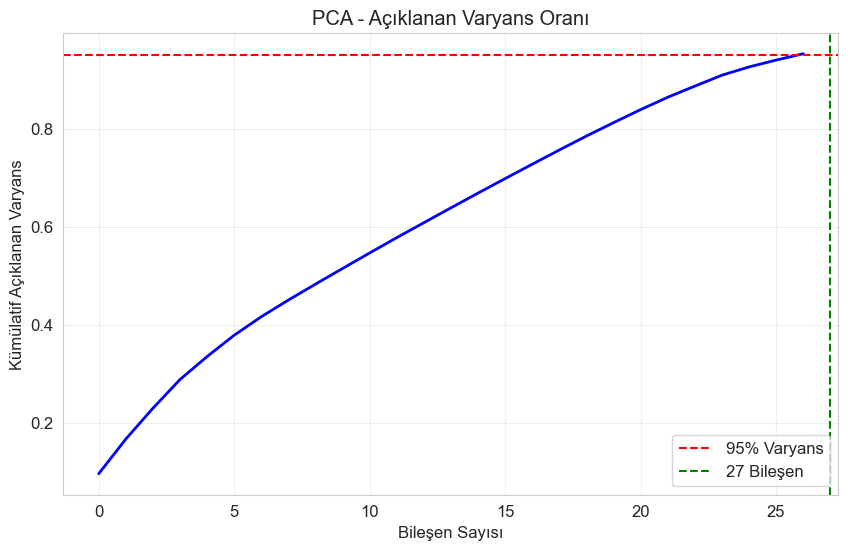

In [7]:
# ==============================================================================
# AŞAMA 6: ÖLÇEKLEME VE BOYUT AZALTMA (GÜNCELLENMİŞ)
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 6: ÖLÇEKLEME VE BOYUT AZALTMA")
print("="*50)

# NOT: Bu aşamada X_train_final, y_train_final, X_test_final, y_test_final kullanılacak
# Daha önceki X_train_smote yerine artık X_train_final kullanıyoruz

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print("✓ Veriler StandardScaler ile ölçeklendi")
print(f"✓ Eğitim verisi boyutu: {X_train_scaled.shape}")
print(f"✓ Test verisi boyutu: {X_test_scaled.shape}")

# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\n✓ Orijinal özellik: {X_train_scaled.shape[1]}")
print(f"✓ PCA sonrası özellik: {pca.n_components_} (%95 varyans)")
print(f"✓ Varyans korunumu: {pca.explained_variance_ratio_.sum():.3f}")

# PCA Grafiği
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'b-', linewidth=2)
plt.xlabel('Bileşen Sayısı')
plt.ylabel('Kümülatif Açıklanan Varyans')
plt.title('PCA - Açıklanan Varyans Oranı')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varyans')
plt.axvline(x=pca.n_components_, color='g', linestyle='--', label=f'{pca.n_components_} Bileşen')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [8]:
# ==============================================================================
# AŞAMA 7: STRATIFIED K-FOLD CROSS VALIDATION 
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 7: STRATIFIED K-FOLD CROSS VALIDATION")
print("="*50)

print("\nStratified K-Fold Cross Validation Uygulanıyor...")
print("-"*40)

# Veriyi küçült (hız için) - artık y_train_final kullanıyoruz
sample_indices = []
for class_label in np.unique(y_train_final):
    class_indices = np.where(y_train_final == class_label)[0]
    if len(class_indices) > 50000:
        selected = np.random.choice(class_indices, size=50000, replace=False)
    else:
        selected = class_indices
    sample_indices.extend(selected)

sample_indices = np.array(sample_indices)
X_small = X_train_scaled[sample_indices]
y_small = y_train_final.iloc[sample_indices]

# Stratified K-Fold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
print(f"✓ K-Fold sayısı: {skf.n_splits}")
print(f"✓ Küçültülmüş veri boyutu: {X_small.shape}")
print(f"✓ Küçültülmüş hedef boyutu: {y_small.shape}")


AŞAMA 7: STRATIFIED K-FOLD CROSS VALIDATION

Stratified K-Fold Cross Validation Uygulanıyor...
----------------------------------------
✓ K-Fold sayısı: 3
✓ Küçültülmüş veri boyutu: (200000, 33)
✓ Küçültülmüş hedef boyutu: (200000,)


In [9]:
# XGBoost modeli oluşturma ve eğitme
print("\nXGBoost modeli eğitiliyor...")

# num_classes değişkenini tanımla
num_classes = len(np.unique(y_train))

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric='mlogloss',
    use_label_encoder=False
)

model.fit(X_train, y_train)

print("Model eğitimi tamamlandı!")

# Tahminler
y_pred = model.predict(X_test)

# Model değerlendirme
print("\n" + "="*50)
print("MODEL DEĞERLENDİRME SONUÇLARI")
print("="*50)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluğu: {accuracy:.4f}")

print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=[f"Severity_{i}" for i in range(num_classes)]))

print("\nKarmaşıklık Matrisi:")
print(confusion_matrix(y_test, y_pred))

# Özellik önemlilikleri
print("\nÖzellik Önemlilikleri:")

# model_features değişkeni tanımlı mı kontrol et
if 'model_features' not in locals():
    # Eğer model_features yoksa, özellik sayısına göre isim oluştur
    num_features = X_train.shape[1]
    model_features = [f"Feature_{i+1}" for i in range(num_features)]

feature_importance = pd.DataFrame({
    'feature': model_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)


XGBoost modeli eğitiliyor...
Model eğitimi tamamlandı!

MODEL DEĞERLENDİRME SONUÇLARI
Model Doğruluğu: 0.7802

Sınıflandırma Raporu:
              precision    recall  f1-score   support

  Severity_0       0.65      0.02      0.03      3483
  Severity_1       0.78      0.99      0.88    281120
  Severity_2       0.56      0.04      0.08     67425
  Severity_3       0.33      0.00      0.00      9543

    accuracy                           0.78    361571
   macro avg       0.58      0.26      0.25    361571
weighted avg       0.73      0.78      0.70    361571


Karmaşıklık Matrisi:
[[    60   3421      2      0]
 [    30 279212   1874      4]
 [     2  64597   2824      2]
 [     1   9165    374      3]]

Özellik Önemlilikleri:
       feature  importance
18  Feature_19    0.275542
24  Feature_25    0.124720
5    Feature_6    0.096164
23  Feature_24    0.091925
16  Feature_17    0.049262
11  Feature_12    0.039378
14  Feature_15    0.039024
32  Feature_33    0.031833
30  Feature_31   

In [10]:
print("\n" + "="*50)
print("AŞAMA 7: MODELLEME (BELLEK OPTİMİZE)")
print("="*50)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# --- 7.1. Baseline Model (Temel Model) ---
print("\n--- 7.1. Baseline Model (Dummy Classifier) ---")

y_train = y_train_final
y_test = y_test_final

print(f"✓ y_train_final boyutu: {len(y_train):,}")
print(f"✓ y_test_final boyutu: {len(y_test):,}")

# VERİYİ KÜÇÜLT (Memory için)
print("\n⚠️  Bellek için veri küçültülüyor...")
sample_size = 50000  # 50K örnek

# Rastgele örnek seç
indices = np.random.choice(len(X_train_pca), size=min(sample_size, len(X_train_pca)), replace=False)
X_train_small = X_train_pca[indices]
y_train_small = y_train.iloc[indices] if hasattr(y_train, 'iloc') else y_train[indices]

print(f"✓ Küçültülmüş eğitim: {X_train_small.shape}")

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_clf.fit(X_train_small, y_train_small)
y_pred_dummy = dummy_clf.predict(X_test_pca)
print(f"Baseline Model Doğruluğu: {accuracy_score(y_test, y_pred_dummy):.4f}")

# --- 7.2. Aday Model: Lojistik Regresyon (BELLEK DOSTU) ---
print("\n--- 7.2. Aday Model: Lojistik Regresyon (Bellek Optimize) ---")
print("Hiper-parametre optimizasyonu başlatılıyor...")

# DAHA KÜÇÜK PARAMETRE GRID
param_grid = {'C': [0.1, 1.0]}  # Sadece 2 değer

# BELLEK DOSTU LogisticRegression
log_reg = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs', 
    max_iter=500,  # Daha az iterasyon
    random_state=42,
    verbose=0,
    n_jobs=1  # Paralel işlemi kapat (memory için)
)

# GridSearchCV'yi optimize et
grid_search = GridSearchCV(
    estimator=log_reg, 
    param_grid=param_grid, 
    cv=2,  # 2-fold CV (daha hızlı)
    n_jobs=1,  # Paralel işlemi kapat
    verbose=1, 
    scoring='accuracy'
)

print(f"Eğitim verisi boyutu: {X_train_small.shape}")
grid_search.fit(X_train_small, y_train_small)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# Test setinde değerlendirme
print("\nTest setinde değerlendirme...")
y_pred_lr = best_model.predict(X_test_pca)
print(f"Lojistik Regresyon Doğruluğu: {accuracy_score(y_test, y_pred_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))


AŞAMA 7: MODELLEME (BELLEK OPTİMİZE)

--- 7.1. Baseline Model (Dummy Classifier) ---
✓ y_train_final boyutu: 4,497,908
✓ y_test_final boyutu: 361,571

⚠️  Bellek için veri küçültülüyor...
✓ Küçültülmüş eğitim: (50000, 27)
Baseline Model Doğruluğu: 0.0264

--- 7.2. Aday Model: Lojistik Regresyon (Bellek Optimize) ---
Hiper-parametre optimizasyonu başlatılıyor...
Eğitim verisi boyutu: (50000, 27)
Fitting 2 folds for each of 2 candidates, totalling 4 fits

En iyi parametreler: {'C': 1.0}

Test setinde değerlendirme...
Lojistik Regresyon Doğruluğu: 0.4658

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.40      0.07      3483
           1       0.82      0.47      0.60    281120
           2       0.28      0.50      0.36     67425
           3       0.03      0.15      0.05      9543

    accuracy                           0.47    361571
   macro avg       0.29      0.38      0.27    361571
weighted avg       0.69      0.47    

In [18]:
# ==============================================================================
# AŞAMA 7.3: HİPERPARAMETRE AYARLI MODEL GELİŞTİRME (STRATIFY OPTİMİZE)
# ==============================================================================
print("\n" + "="*50)
print("AŞAMA 7.3: EXTRA TREES & HISTGRADIENTBOOSTING (STRATIFY OPTİMİZE)")
print("="*50)

# Gerekli kütüphaneler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
import numpy as np

# Model değerlendirme fonksiyonu
def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):
    """Model performansını kapsamlı değerlendirir ve yazdırır."""
    print(f"\n{'='*60}")
    print(f"{model_name} - KAPSAMLI DEĞERLENDİRME")
    print('='*60)
    
    # Temel metrikler
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"📊 Temel Metrikler:")
    print(f"   Accuracy (Doğruluk):          {acc:.4f}")
    print(f"   Precision (Kesinlik) - Wght: {precision:.4f}")
    print(f"   Recall (Duyarlılık) - Wght:  {recall:.4f}")
    print(f"   F1-Score - Wght:              {f1:.4f}")
    
    # Eğer olasılık tahminleri varsa AUC hesapla
    if y_pred_proba is not None:
        try:
            # Çok sınıflı AUC (One-vs-Rest)
            auc_macro = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='macro')
            auc_weighted = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')
            print(f"\n📈 AUC (ROC Alanı Altında Kalan Alan):")
            print(f"   Macro AUC:     {auc_macro:.4f}")
            print(f"   Weighted AUC:  {auc_weighted:.4f}")
        except Exception as e:
            print(f"\n⚠️  AUC hesaplanamadı: {e}")
    
    # Detaylı sınıf bazlı rapor
    print(f"\n📋 Detaylı Sınıf Bazlı Metrikler:")
    print(classification_report(y_true, y_pred, target_names=[f'Severity_{i}' for i in range(4)], zero_division=0))
    
    # Karmaşıklık matrisi
    print(f"📊 Karmaşıklık Matrisi:")
    print(confusion_matrix(y_true, y_pred))
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_macro': auc_macro if 'auc_macro' in locals() else None,
        'auc_weighted': auc_weighted if 'auc_weighted' in locals() else None
    }

# Stratified veri küçültme
print("\n⚠️  HIZ için eğitim verisi küçültülüyor - STRATIFY ile...")
final_sample_size = 100000

# Stratify ile veri küçültme (sınıf dağılımını koruyarak)
if final_sample_size < len(X_train_pca):
    # Oran hesapla
    sample_ratio = final_sample_size / len(X_train_pca)
    
    # Stratify ile küçültme
    X_train_final_small, _, y_train_final_small, _ = train_test_split(
        X_train_pca, 
        y_train_final,
        train_size=sample_ratio,
        stratify=y_train_final,  # ✅ STRATIFY EKLENDİ
        random_state=42
    )
else:
    # Eğer sample boyutu büyükse tüm veriyi kullan
    X_train_final_small = X_train_pca
    y_train_final_small = y_train_final

print(f"✓ Eğitim seti boyutu: {X_train_final_small.shape}")
print(f"✓ Test seti boyutu: {X_test_pca.shape}")
print(f"✓ Küçültülmüş eğitim seti sınıf dağılımı:")
print(f"  {np.bincount(y_train_final_small)}")
print(f"✓ Orijinal test seti sınıf dağılımı:")
print(f"  {np.bincount(y_test_final)}")

# Stratified K-Fold tanımla (tüm modeller için ortak)
stratified_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# ==============================================================================
# 1. EXTRA TREES CLASSIFIER (STRATIFY OPTİMİZE)
# ==============================================================================
print("\n" + "="*60)
print("1. EXTRA TREES CLASSIFIER - STRATIFY OPTİMİZE")
print("="*60)

# Daha küçük ve hızlı bir parametre dağılımı
param_dist_et = {
    'n_estimators': [50, 100],           # Ağaç sayısını azalt
    'max_depth': [15, 20, None],         # Derinlik sınırı
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2'],    # Her bölünmede kullanılacak özellik sayısı
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']   # ✅ Sınıf dengesizliği için
}

# Bellek dostu ExtraTrees
et = ExtraTreesClassifier(
    random_state=42,
    n_jobs=2,            # Paralel işlem
    verbose=0
)

# RANDOMIZED SEARCH (Stratified CV ile)
random_search_et = RandomizedSearchCV(
    estimator=et,
    param_distributions=param_dist_et,
    n_iter=4,           # Sadece 4 farklı kombinasyon dene
    cv=stratified_cv,   # ✅ STRATIFIED CV EKLENDİ
    scoring='accuracy',
    n_jobs=1,           # Paralel işlemi kapat (bellek için)
    random_state=42,
    verbose=1
)

print("🔍 ExtraTrees için RandomizedSearch başlatılıyor (Stratified CV ile)...")
random_search_et.fit(X_train_final_small, y_train_final_small)

print(f"\n✅ ExtraTrees En İyi Parametreler: {random_search_et.best_params_}")
print(f"✅ ExtraTrees En İyi CV Skoru: {random_search_et.best_score_:.4f}")

# En iyi modeli al ve test setinde değerlendir
best_et = random_search_et.best_estimator_
y_pred_et = best_et.predict(X_test_pca)
y_pred_proba_et = best_et.predict_proba(X_test_pca)

# Performans değerlendirme
et_metrics = evaluate_model("EXTRA TREES CLASSIFIER (STRATIFY)", y_test_final, y_pred_et, y_pred_proba_et)

# ==============================================================================
# 2. HISTGRADIENTBOOSTING CLASSIFIER (STRATIFY OPTİMİZE)
# ==============================================================================
print("\n" + "="*60)
print("2. HISTGRADIENTBOOSTING CLASSIFIER - STRATIFY OPTİMİZE")
print("="*60)

# HistGradientBoosting için parametreler (bellek dostu)
param_dist_hgb = {
    'max_iter': [50, 100],            # İterasyon sayısı
    'max_depth': [5, 10],             # Daha sığ ağaçlar
    'learning_rate': [0.05, 0.1],     # Öğrenme oranı
    'min_samples_leaf': [10, 20],     # Yaprak başına minimum örnek
    'l2_regularization': [0, 0.1],    # Regularizasyon
    'class_weight': [None, 'balanced']  # ✅ Sınıf dengesizliği için
}

# HistGradientBoosting modeli
hgb = HistGradientBoostingClassifier(
    random_state=42,
    early_stopping=False,      # Erken durdurmayı kapat (hız için)
    verbose=0
)

# RandomizedSearchCV (Stratified CV ile)
random_search_hgb = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist_hgb,
    n_iter=3,           # Sadece 3 kombinasyon
    cv=stratified_cv,   # ✅ STRATIFIED CV EKLENDİ
    scoring='accuracy',
    n_jobs=1,           # Paralel işlem yok
    random_state=42,
    verbose=1
)

print("🔍 HistGradientBoosting için RandomizedSearch başlatılıyor (Stratified CV ile)...")
random_search_hgb.fit(X_train_final_small, y_train_final_small)

print(f"\n✅ HistGradientBoosting En İyi Parametreler: {random_search_hgb.best_params_}")
print(f"✅ HistGradientBoosting En İyi CV Skoru: {random_search_hgb.best_score_:.4f}")

# En iyi modeli al ve test setinde değerlendir
best_hgb = random_search_hgb.best_estimator_
y_pred_hgb = best_hgb.predict(X_test_pca)
y_pred_proba_hgb = best_hgb.predict_proba(X_test_pca)

# Performans değerlendirme
hgb_metrics = evaluate_model("HISTGRADIENTBOOSTING CLASSIFIER (STRATIFY)", y_test_final, y_pred_hgb, y_pred_proba_hgb)

# ==============================================================================
# 3. MODEL KARŞILAŞTIRMASI
# ==============================================================================
print("\n" + "="*60)
print("MODEL KARŞILAŞTIRMASI")
print("="*60)

print("\n📊 PERFORMANS KARŞILAŞTIRMASI:")
print("-" * 50)
print(f"{'METRİK':<20} {'ExtraTrees':<15} {'HistGradient':<15}")
print("-" * 50)
print(f"{'Accuracy':<20} {et_metrics['accuracy']:<15.4f} {hgb_metrics['accuracy']:<15.4f}")
print(f"{'F1-Score':<20} {et_metrics['f1']:<15.4f} {hgb_metrics['f1']:<15.4f}")
print(f"{'Precision':<20} {et_metrics['precision']:<15.4f} {hgb_metrics['precision']:<15.4f}")
print(f"{'Recall':<20} {et_metrics['recall']:<15.4f} {hgb_metrics['recall']:<15.4f}")

if et_metrics['auc_macro'] and hgb_metrics['auc_macro']:
    print(f"{'AUC Macro':<20} {et_metrics['auc_macro']:<15.4f} {hgb_metrics['auc_macro']:<15.4f}")
    print(f"{'AUC Weighted':<20} {et_metrics['auc_weighted']:<15.4f} {hgb_metrics['auc_weighted']:<15.4f}")

# Kazanan modeli belirle
if et_metrics['accuracy'] > hgb_metrics['accuracy']:
    print(f"\n🏆 KAZANAN: ExtraTrees Classifier ({et_metrics['accuracy']:.4f} accuracy)")
    best_model = best_et
    best_model_name = "ExtraTrees"
else:
    print(f"\n🏆 KAZANAN: HistGradientBoosting Classifier ({hgb_metrics['accuracy']:.4f} accuracy)")
    best_model = best_hgb
    best_model_name = "HistGradientBoosting"

print("\n" + "="*60)
print("AŞAMA 7.3 TAMAMLANDI ✓")
print("="*60)


print(f"✓ En iyi model: {best_model_name}")
print(f"✓ Eğitim verisi boyutu: {X_train_final_small.shape}")
print(f"✓ Test verisi boyutu: {X_test_pca.shape}")


AŞAMA 7.3: EXTRA TREES & HISTGRADIENTBOOSTING (STRATIFY OPTİMİZE)

⚠️  HIZ için eğitim verisi küçültülüyor - STRATIFY ile...
✓ Eğitim seti boyutu: (100000, 27)
✓ Test seti boyutu: (361571, 27)
✓ Küçültülmüş eğitim seti sınıf dağılımı:
  [25000 25000 25000 25000]
✓ Orijinal test seti sınıf dağılımı:
  [  3483 281120  67425   9543]

1. EXTRA TREES CLASSIFIER - STRATIFY OPTİMİZE
🔍 ExtraTrees için RandomizedSearch başlatılıyor (Stratified CV ile)...
Fitting 2 folds for each of 4 candidates, totalling 8 fits

✅ ExtraTrees En İyi Parametreler: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': None, 'bootstrap': False}
✅ ExtraTrees En İyi CV Skoru: 0.6083

EXTRA TREES CLASSIFIER (STRATIFY) - KAPSAMLI DEĞERLENDİRME
📊 Temel Metrikler:
   Accuracy (Doğruluk):          0.5922
   Precision (Kesinlik) - Wght: 0.7080
   Recall (Duyarlılık) - Wght:  0.5922
   F1-Score - Wght:              0.6374

📈 AUC (ROC Alanı Altında Ka


AŞAMA 7.4: MODEL KARŞILAŞTIRMA VE PERFORMANS DEĞERLENDİRMESİ

📊 XGBoost modeli değerlendiriliyor...
   ✓ Accuracy: 0.5937
   ✓ F1-Score: 0.6400

📊 Logistic Regression modeli değerlendiriliyor...
   ✓ Accuracy: 0.4523
   ✓ F1-Score: 0.5209

📊 Extra Trees modeli değerlendiriliyor...
   ✓ Accuracy: 0.5922
   ✓ F1-Score: 0.6374
   ✓ AUC: 0.6379

📊 HistGradientBoosting modeli değerlendiriliyor...
   ✓ Accuracy: 0.5839
   ✓ F1-Score: 0.6331
   ✓ AUC: 0.6344

MODEL PERFORMANS KARŞILAŞTIRMASI

📈 Tüm Modellerin Performans Metrikleri:
               Model  Accuracy  Precision   Recall  F1-Score      AUC
             XGBoost  0.593662   0.711797 0.593662  0.639964      NaN
 Logistic Regression  0.452276   0.688581 0.452276  0.520903      NaN
         Extra Trees  0.592188   0.708017 0.592188  0.637441 0.637893
HistGradientBoosting  0.583855   0.711345 0.583855  0.633076 0.634368

🏆 PERFORMANS SIRALAMALARI
--------------------------------------------------

1. Accuracy (Doğruluk) Sıralaması:
    

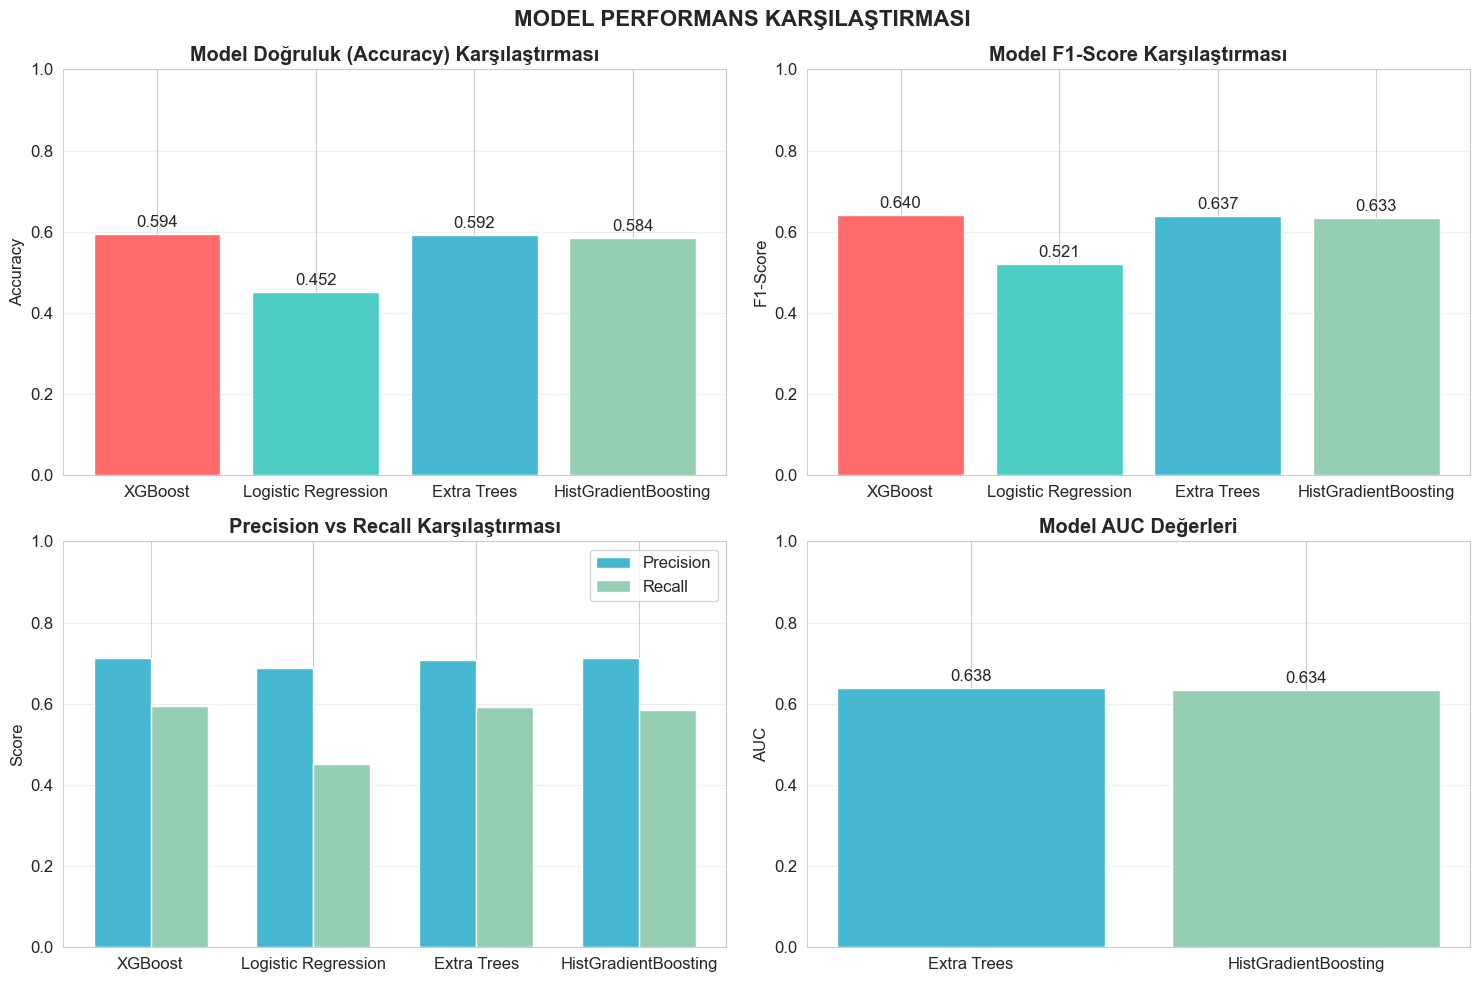


🔥 Isı Haritası ile Model Performans Karşılaştırması


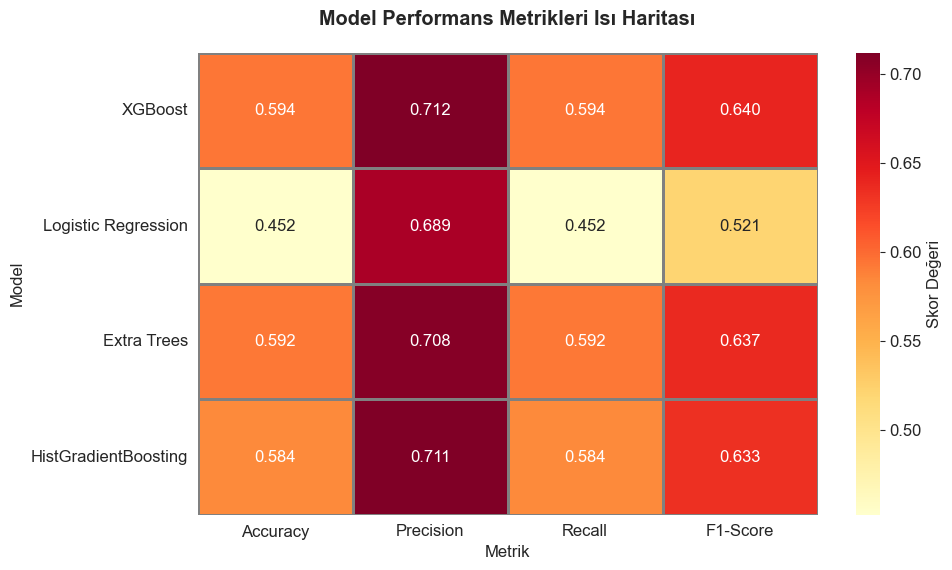


📊 Radar Chart ile Çok Boyutlu Performans Analizi


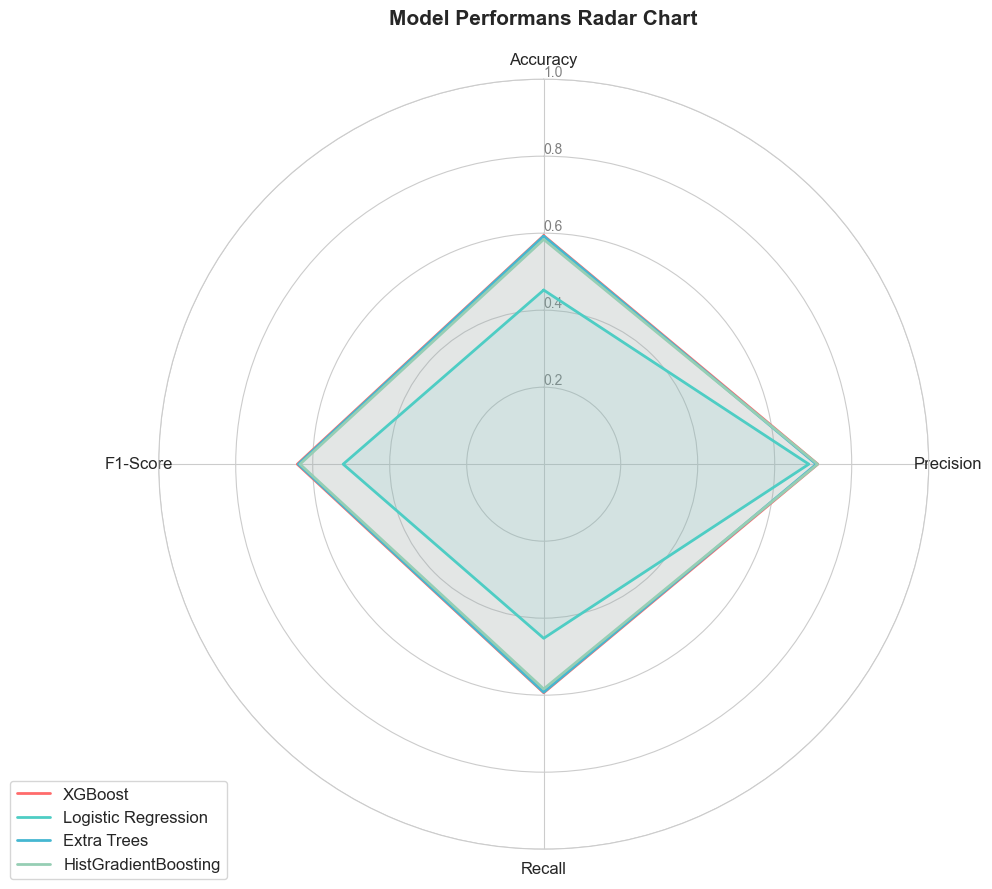


KARMAŞIKLIK MATRİSLERİ KARŞILAŞTIRMASI


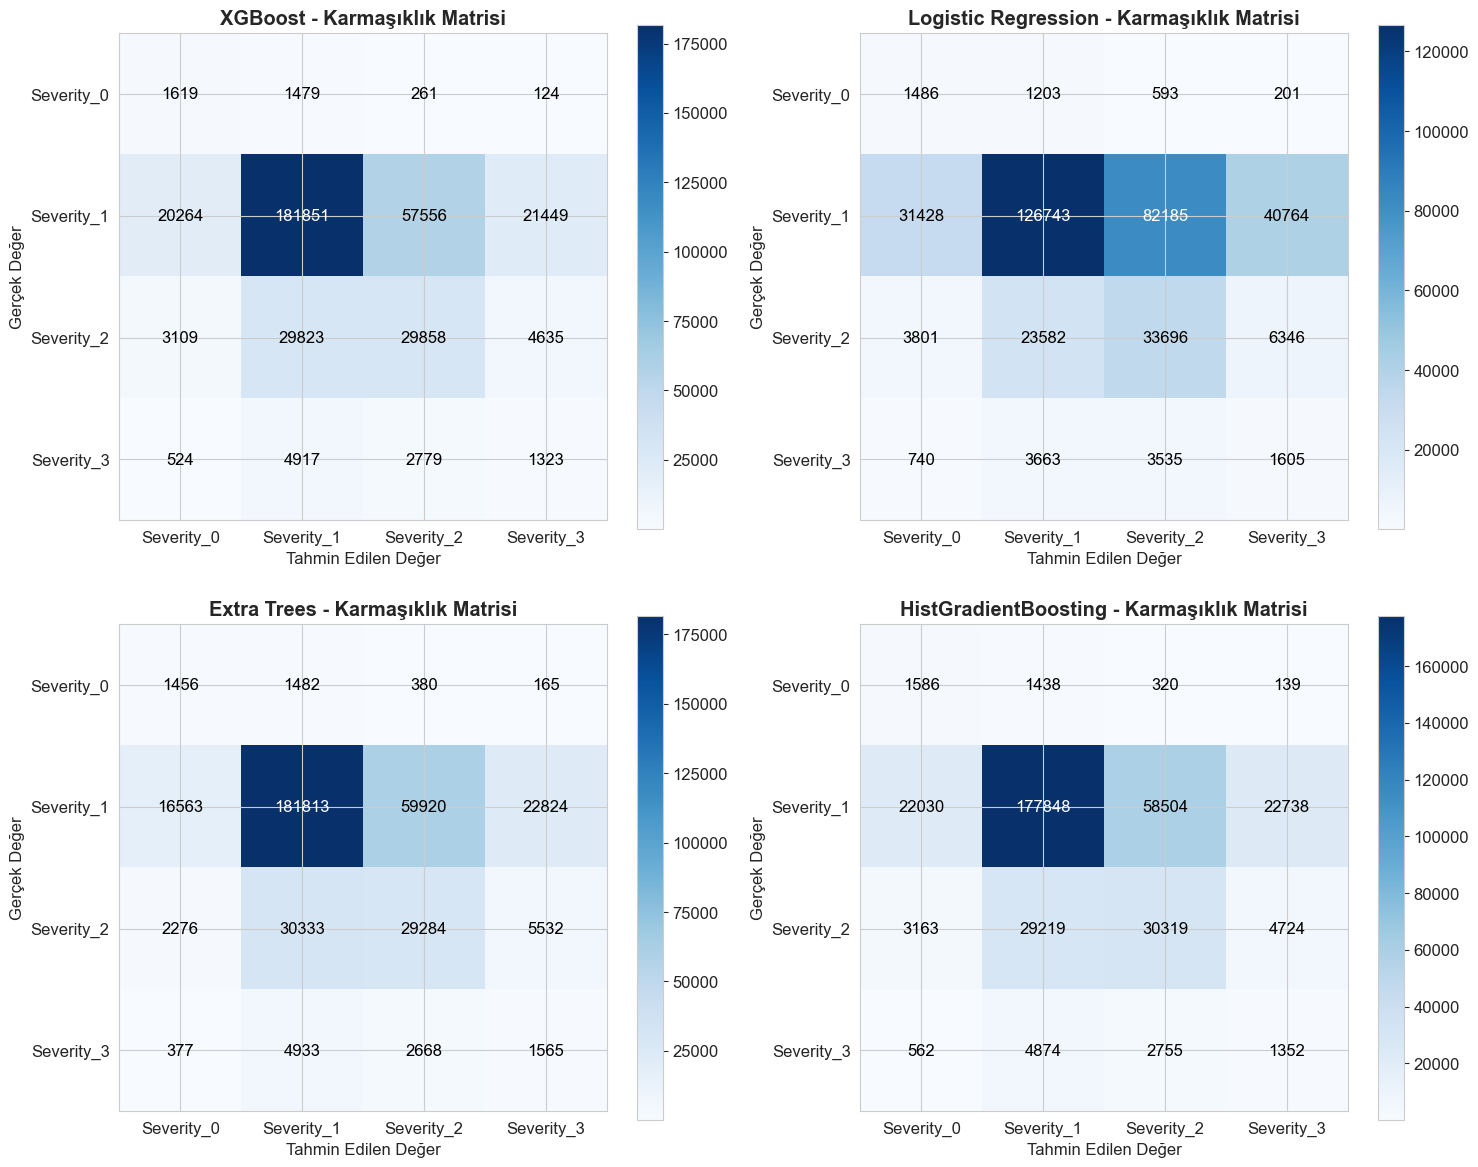


DETAYLI PERFORMANS ANALİZİ VE ÖNERİLER

🏆 EN İYİ PERFORMANS GÖSTEREN MODEL: XGBoost
   - Accuracy: 0.5937
   - F1-Score: 0.6400

🥈 İKİNCİ EN İYİ MODEL: Extra Trees
   - Accuracy: 0.5922

⚠️  DİKKAT: En iyi iki model arasındaki fark çok küçük (0.0015)
   Bu modellerin performansı istatistiksel olarak benzer olabilir.

💡 MODEL SEÇİM ÖNERİLERİ:
----------------------------------------

🔍 XGBoost Hakkında:
   ✅ Güçlü Yönler: Güçlü öğrenme kapasitesi, özellik önemlilikleri, overfitting'e karşı direnç
   ⚠️  Zayıf Yönler: Hesaplama maliyeti yüksek, hiperparametre ayarı önemli
   💡 Öneri: Büyük veri setleri ve karmaşık ilişkiler için uygun

SONUÇ ÖZETİ

📋 Toplam Değerlendirilen Model Sayısı: 4
🏆 En Başarılı Model: XGBoost (Accuracy: 0.5937)
📊 Tüm Modellerin Ortalama Accuracy'si: 0.5555
📊 Tüm Modellerin Ortalama F1-Score'u: 0.6078

✅ MODEL KARŞILAŞTIRMA TAMAMLANDI!
   Modellerin performans metrikleri başarıyla karşılaştırıldı ve görselleştirildi.


In [19]:
print("\n" + "="*70)
print("AŞAMA 7.4: MODEL KARŞILAŞTIRMA VE PERFORMANS DEĞERLENDİRMESİ")
print("="*70)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.preprocessing import label_binarize

# Önce tüm tahminleri bir araya topla
models = {
    'XGBoost': (y_pred, None),  # Olasılık tahminleri yoksa None
    'Logistic Regression': (y_pred_lr, None),
    'Extra Trees': (y_pred_et, y_pred_proba_et),
    'HistGradientBoosting': (y_pred_hgb, y_pred_proba_hgb)
}

# Model performans metriklerini saklamak için liste
performance_results = []

# Test etiketlerini ortak değişkene ata
y_true = y_test_final

# Her model için metrikleri hesapla
for model_name, (y_pred, y_proba) in models.items():
    print(f"\n📊 {model_name} modeli değerlendiriliyor...")
    
    # Temel metrikler
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Eğer olasılık tahminleri varsa AUC hesapla
    auc_score = None
    if y_proba is not None:
        try:
            # Çok sınıflı AUC
            auc_score = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
        except:
            auc_score = None
    
    # Performans sonuçlarını kaydet
    performance_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_score if auc_score is not None else np.nan
    })
    
    print(f"   ✓ Accuracy: {acc:.4f}")
    print(f"   ✓ F1-Score: {f1:.4f}")
    if auc_score:
        print(f"   ✓ AUC: {auc_score:.4f}")

# Performans sonuçlarını DataFrame'e dönüştür
performance_df = pd.DataFrame(performance_results)
print("\n" + "="*70)
print("MODEL PERFORMANS KARŞILAŞTIRMASI")
print("="*70)
print("\n📈 Tüm Modellerin Performans Metrikleri:")
print(performance_df.to_string(index=False))

# Metrik türlerine göre sıralama
print("\n🏆 PERFORMANS SIRALAMALARI")
print("-" * 50)

# Accuracy'e göre sırala
print("\n1. Accuracy (Doğruluk) Sıralaması:")
accuracy_sorted = performance_df.sort_values('Accuracy', ascending=False)[['Model', 'Accuracy']]
print(accuracy_sorted.to_string(index=False))

# F1-Score'a göre sırala
print("\n2. F1-Score (Harmonik Ortalama) Sıralaması:")
f1_sorted = performance_df.sort_values('F1-Score', ascending=False)[['Model', 'F1-Score']]
print(f1_sorted.to_string(index=False))

# AUC'ye göre sırala (mevcutsa)
if performance_df['AUC'].notna().any():
    print("\n3. AUC (ROC Alanı) Sıralaması:")
    auc_sorted = performance_df.sort_values('AUC', ascending=False)[['Model', 'AUC']]
    print(auc_sorted.to_string(index=False))

# GÖRSELLEŞTİRMELER
print("\n" + "="*70)
print("GÖRSELLEŞTİRMELER")
print("="*70)

# 1. MODEL PERFORMANS KARŞILAŞTIRMA GRAFİĞİ
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('MODEL PERFORMANS KARŞILAŞTIRMASI', fontsize=16, fontweight='bold')

# Accuracy karşılaştırması
ax1 = axes[0, 0]
bars1 = ax1.bar(performance_df['Model'], performance_df['Accuracy'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax1.set_title('Model Doğruluk (Accuracy) Karşılaştırması', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
# Değerleri çubukların üzerine yaz
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# F1-Score karşılaştırması
ax2 = axes[0, 1]
bars2 = ax2.bar(performance_df['Model'], performance_df['F1-Score'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.set_title('Model F1-Score Karşılaştırması', fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
# Değerleri çubukların üzerine yaz
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# Precision-Recall karşılaştırması
ax3 = axes[1, 0]
x = np.arange(len(performance_df))
width = 0.35
bars3a = ax3.bar(x - width/2, performance_df['Precision'], width, label='Precision', color='#45B7D1')
bars3b = ax3.bar(x + width/2, performance_df['Recall'], width, label='Recall', color='#96CEB4')
ax3.set_title('Precision vs Recall Karşılaştırması', fontweight='bold')
ax3.set_ylabel('Score')
ax3.set_xticks(x)
ax3.set_xticklabels(performance_df['Model'])
ax3.legend()
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)

# AUC karşılaştırması (mevcutsa)
if performance_df['AUC'].notna().any():
    ax4 = axes[1, 1]
    models_with_auc = performance_df[performance_df['AUC'].notna()]
    bars4 = ax4.bar(models_with_auc['Model'], models_with_auc['AUC'], color=['#45B7D1', '#96CEB4'])
    ax4.set_title('Model AUC Değerleri', fontweight='bold')
    ax4.set_ylabel('AUC')
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3)
    # Değerleri çubukların üzerine yaz
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
else:
    axes[1, 1].axis('off')
    axes[1, 1].text(0.5, 0.5, 'AUC verisi yok', 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    fontsize=12)

plt.tight_layout()
plt.show()

# 2. HEATMAP İLE PERFORMANS KARŞILAŞTIRMASI
print("\n🔥 Isı Haritası ile Model Performans Karşılaştırması")

# Metrikleri normalize et (0-1 arası)
metrics_for_heatmap = performance_df.set_index('Model')
# AUC'yi çıkar çünkü tüm modellerde olmayabilir
if 'AUC' in metrics_for_heatmap.columns:
    metrics_for_heatmap = metrics_for_heatmap[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
else:
    metrics_for_heatmap = metrics_for_heatmap[['Accuracy', 'Precision', 'Recall', 'F1-Score']]

plt.figure(figsize=(10, 6))
sns.heatmap(metrics_for_heatmap, annot=True, fmt='.3f', cmap='YlOrRd', 
            linewidths=1, linecolor='gray', cbar_kws={'label': 'Skor Değeri'})
plt.title('Model Performans Metrikleri Isı Haritası', fontweight='bold', pad=20)
plt.ylabel('Model')
plt.xlabel('Metrik')
plt.show()

# 3. RADAR CHART İLE MODEL KARŞILAŞTIRMASI
print("\n📊 Radar Chart ile Çok Boyutlu Performans Analizi")

from math import pi

# Radar chart için metrikleri hazırla
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
num_metrics = len(metrics)

# Her model için metrik değerleri
model_data = []
model_names = []
for _, row in performance_df.iterrows():
    model_names.append(row['Model'])
    model_data.append([row[m] for m in metrics])

# Açılar
angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
angles += angles[:1]  # Kapatmak için

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# X ekseni etiketleri
plt.xticks(angles[:-1], metrics)

# Y ekseni
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1)

# Her model için çiz
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for i, (data, name, color) in enumerate(zip(model_data, model_names, colors)):
    values = data + data[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=name, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

plt.title('Model Performans Radar Chart', size=15, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# 4. KARMAŞIKLIK MATRİSLERİNİ KARŞILAŞTIRMA
print("\n" + "="*70)
print("KARMAŞIKLIK MATRİSLERİ KARŞILAŞTIRMASI")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (model_name, (y_pred, _)) in enumerate(models.items()):
    if idx < len(axes):
        cm = confusion_matrix(y_true, y_pred)
        ax = axes[idx]
        
        # Isı haritası olarak göster
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        
        # Sınıf etiketleri
        classes = np.unique(y_true)
        tick_marks = np.arange(len(classes))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)
        ax.set_xticklabels([f'Severity_{c}' for c in classes])
        ax.set_yticklabels([f'Severity_{c}' for c in classes])
        
        # Hücrelere değerleri yaz
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black")
        
        ax.set_title(f'{model_name} - Karmaşıklık Matrisi', fontweight='bold')
        ax.set_ylabel('Gerçek Değer')
        ax.set_xlabel('Tahmin Edilen Değer')

plt.tight_layout()
plt.show()

# 5. DETAYLI PERFORMANS ANALİZİ
print("\n" + "="*70)
print("DETAYLI PERFORMANS ANALİZİ VE ÖNERİLER")
print("="*70)

# En iyi modeli belirle (Accuracy'e göre)
best_model_name = performance_df.loc[performance_df['Accuracy'].idxmax(), 'Model']
best_accuracy = performance_df.loc[performance_df['Accuracy'].idxmax(), 'Accuracy']
second_best_model_name = performance_df.nlargest(2, 'Accuracy').iloc[1]['Model']
second_best_accuracy = performance_df.nlargest(2, 'Accuracy').iloc[1]['Accuracy']

print(f"\n🏆 EN İYİ PERFORMANS GÖSTEREN MODEL: {best_model_name}")
print(f"   - Accuracy: {best_accuracy:.4f}")
print(f"   - F1-Score: {performance_df.loc[performance_df['Model'] == best_model_name, 'F1-Score'].values[0]:.4f}")

print(f"\n🥈 İKİNCİ EN İYİ MODEL: {second_best_model_name}")
print(f"   - Accuracy: {second_best_accuracy:.4f}")

# Performans farklarını analiz et
accuracy_diff = best_accuracy - second_best_accuracy
if accuracy_diff < 0.01:
    print(f"\n⚠️  DİKKAT: En iyi iki model arasındaki fark çok küçük ({accuracy_diff:.4f})")
    print("   Bu modellerin performansı istatistiksel olarak benzer olabilir.")
else:
    print(f"\n✅ En iyi model, ikinci en iyi modelden {accuracy_diff:.4f} kadar daha iyi.")

# Model önerileri
print("\n💡 MODEL SEÇİM ÖNERİLERİ:")
print("-" * 40)

# Her model için güçlü/zayıf yönler
model_insights = {
    'XGBoost': {
        'strengths': 'Güçlü öğrenme kapasitesi, özellik önemlilikleri, overfitting\'e karşı direnç',
        'weaknesses': 'Hesaplama maliyeti yüksek, hiperparametre ayarı önemli',
        'recommendation': 'Büyük veri setleri ve karmaşık ilişkiler için uygun'
    },
    'Logistic Regression': {
        'strengths': 'Hızlı, yorumlanabilir, overfitting\'e karşı dirençli',
        'weaknesses': 'Doğrusal ilişkileri varsayar, karmaşık ilişkileri yakalamakta zorlanır',
        'recommendation': 'Basit ve hızlı çözümler, model yorumlanabilirliği önemliyse'
    },
    'Extra Trees': {
        'strengths': 'Hızlı eğitim, overfitting\'e karşı direnç, özellik önemlilikleri',
        'weaknesses': 'Daha fazla bellek kullanımı, yorumlanabilirlik sınırlı',
        'recommendation': 'Hızlı ve güçlü bir ensemble yöntemi istendiğinde'
    },
    'HistGradientBoosting': {
        'strengths': 'Büyük veri için optimize, bellek verimli, hızlı',
        'weaknesses': 'Hiperparametre ayarı önemli, bazı durumlarda diğer boosting yöntemlerinden daha az güçlü',
        'recommendation': 'Çok büyük veri setleri ve bellek kısıtları olduğunda'
    }
}

# En iyi model için detaylı bilgi
if best_model_name in model_insights:
    insights = model_insights[best_model_name]
    print(f"\n🔍 {best_model_name} Hakkında:")
    print(f"   ✅ Güçlü Yönler: {insights['strengths']}")
    print(f"   ⚠️  Zayıf Yönler: {insights['weaknesses']}")
    print(f"   💡 Öneri: {insights['recommendation']}")

# Sonuç özeti
print("\n" + "="*70)
print("SONUÇ ÖZETİ")
print("="*70)

print(f"\n📋 Toplam Değerlendirilen Model Sayısı: {len(models)}")
print(f"🏆 En Başarılı Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")

# Ortalama performans
mean_accuracy = performance_df['Accuracy'].mean()
mean_f1 = performance_df['F1-Score'].mean()
print(f"📊 Tüm Modellerin Ortalama Accuracy'si: {mean_accuracy:.4f}")
print(f"📊 Tüm Modellerin Ortalama F1-Score'u: {mean_f1:.4f}")

print("\n✅ MODEL KARŞILAŞTIRMA TAMAMLANDI!")
print("   Modellerin performans metrikleri başarıyla karşılaştırıldı ve görselleştirildi.")


ROC AUC ANALİZİ VE GÖRSELLEŞTİRMELERİ

📊 Sınıf Sayısı: 4
📊 Sınıflar: [0 1 2 3]
⚠️  XGBoost olasılık tahminleri alınamadı: Feature shape mismatch, expected: 33, got 27
✓ Logistic Regression olasılık tahminleri alındı
✓ Extra Trees olasılık tahminleri alındı
✓ HistGradientBoosting olasılık tahminleri alındı

📊 Toplam 3 model için ROC AUC analizi yapılacak

1. BİREYSEL SINIF BAZLI ROC EĞRİLERİ

📈 Logistic Regression - Sınıf Bazlı ROC Eğrileri


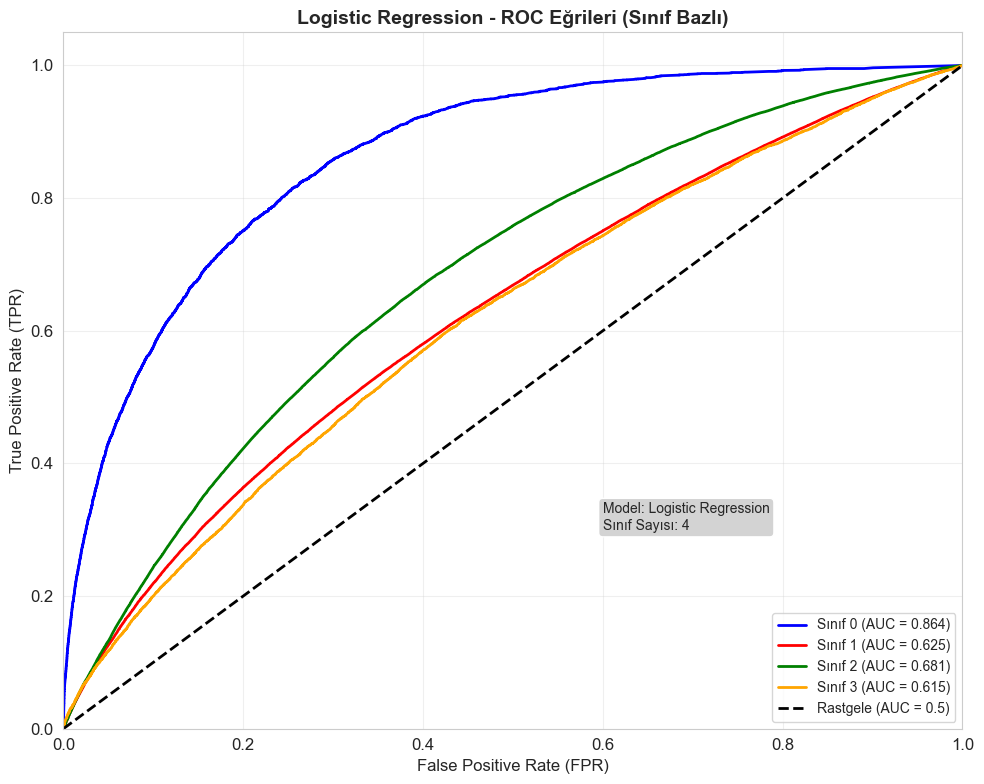


📈 Extra Trees - Sınıf Bazlı ROC Eğrileri


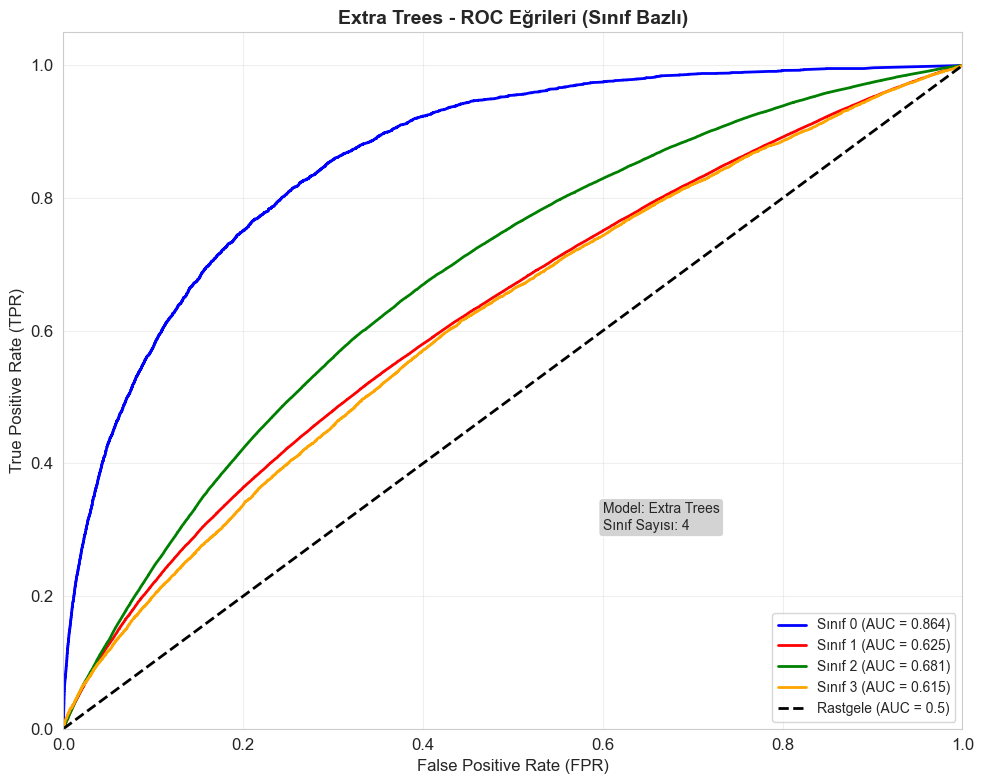


📈 HistGradientBoosting - Sınıf Bazlı ROC Eğrileri


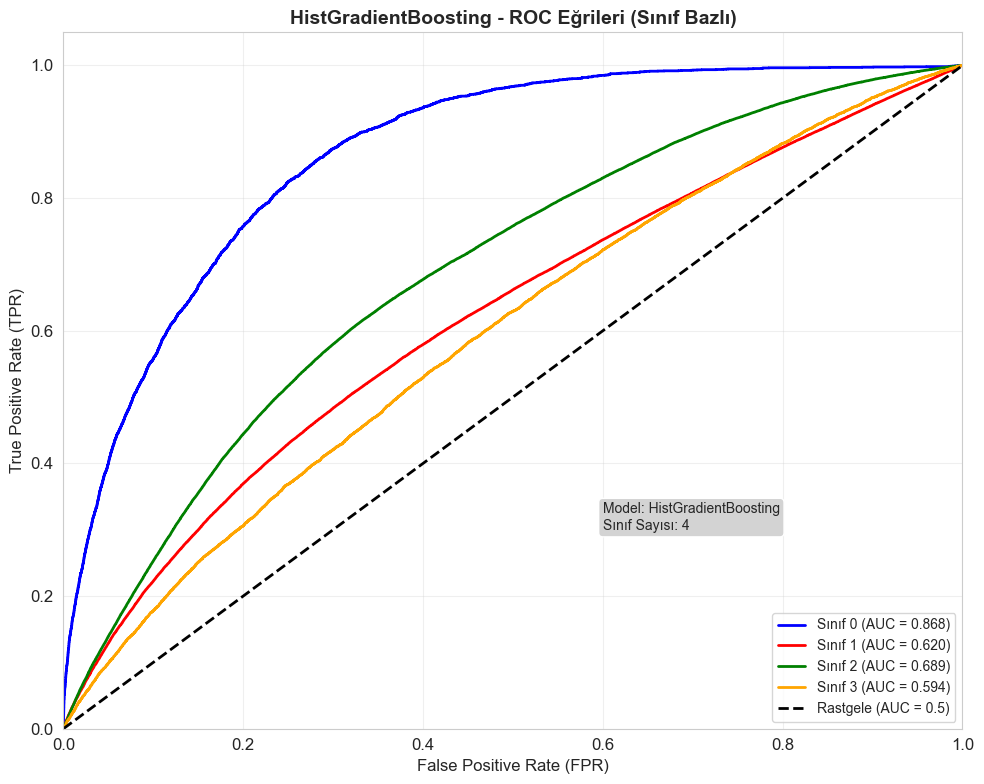


2. MODEL BAZLI ROC EĞRİLERİ KARŞILAŞTIRMASI

📊 Sınıf 0 için ROC Eğrileri:
   ✓ Logistic Regression: AUC = 0.864
   ✓ Extra Trees: AUC = 0.864
   ✓ HistGradientBoosting: AUC = 0.868

📊 Sınıf 1 için ROC Eğrileri:
   ✓ Logistic Regression: AUC = 0.625
   ✓ Extra Trees: AUC = 0.625
   ✓ HistGradientBoosting: AUC = 0.620

📊 Sınıf 2 için ROC Eğrileri:
   ✓ Logistic Regression: AUC = 0.681
   ✓ Extra Trees: AUC = 0.681
   ✓ HistGradientBoosting: AUC = 0.689

📊 Sınıf 3 için ROC Eğrileri:
   ✓ Logistic Regression: AUC = 0.615
   ✓ Extra Trees: AUC = 0.615
   ✓ HistGradientBoosting: AUC = 0.594


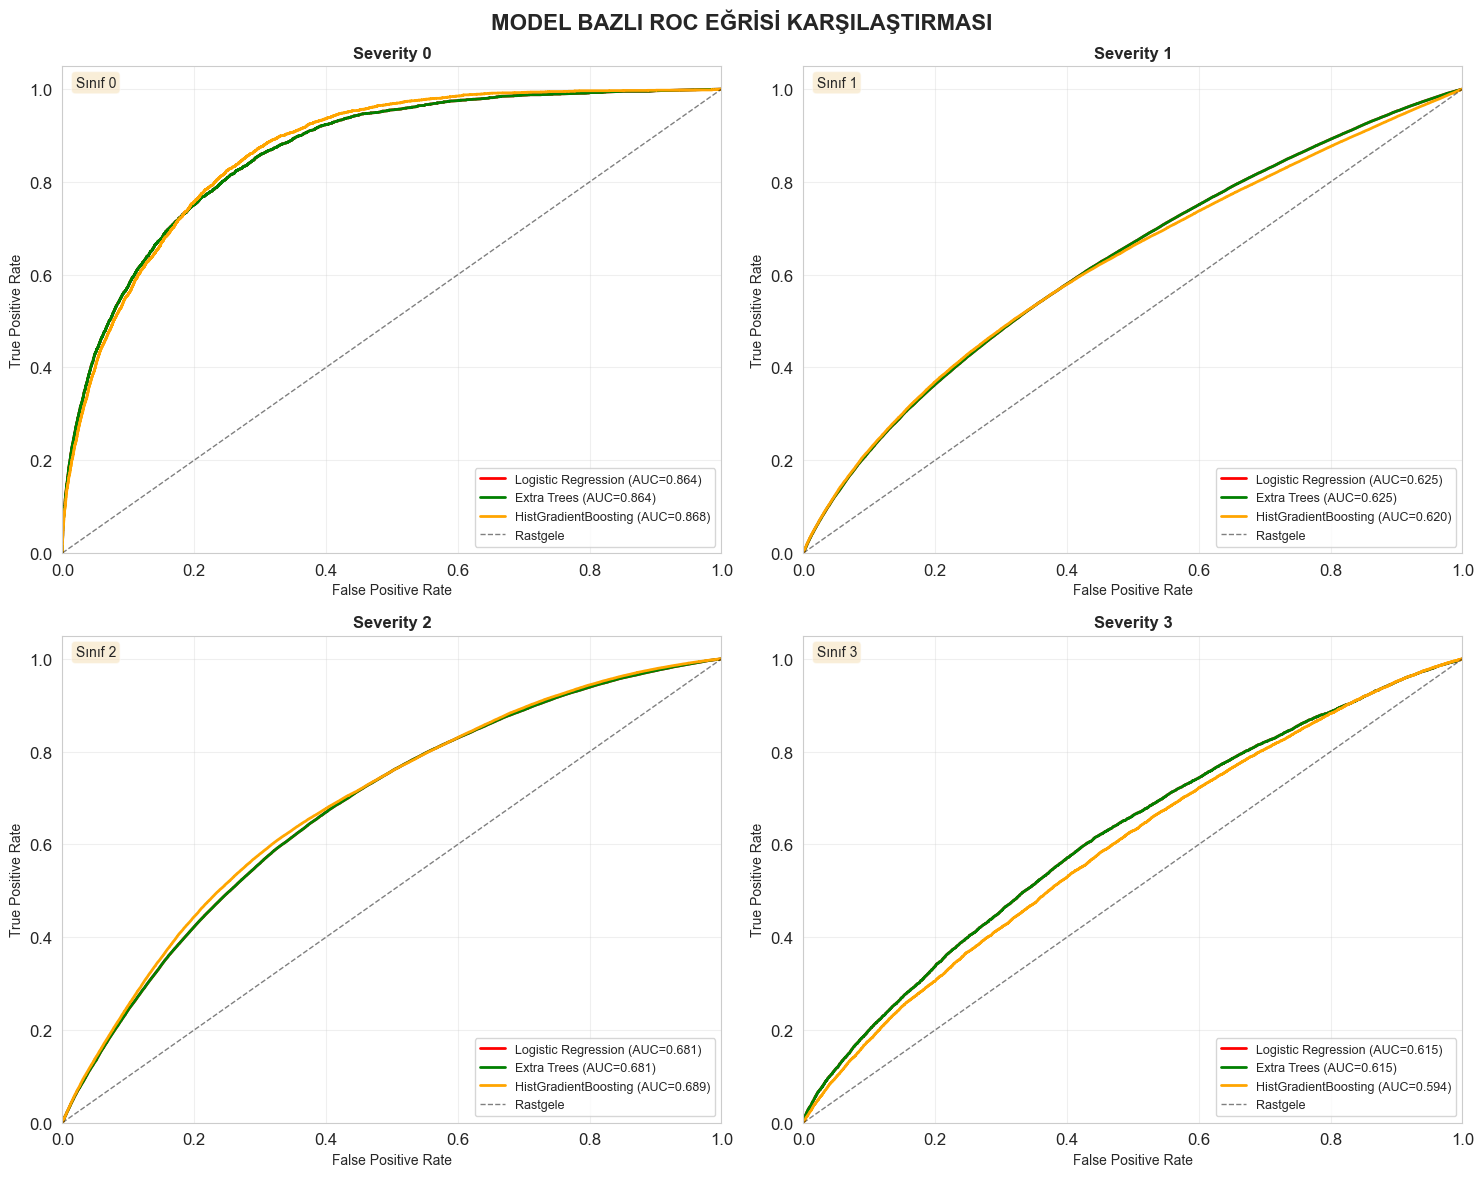


3. MACRO VE WEIGHTED ROC AUC DEĞERLERİ

📊 Logistic Regression:
   ✓ Macro AUC:     0.6965
   ✓ Weighted AUC:  0.6379
   ✓ Sınıf 0 AUC: 0.8640
   ✓ Sınıf 1 AUC: 0.6255
   ✓ Sınıf 2 AUC: 0.6811
   ✓ Sınıf 3 AUC: 0.6153

📊 Extra Trees:
   ✓ Macro AUC:     0.6965
   ✓ Weighted AUC:  0.6379
   ✓ Sınıf 0 AUC: 0.8640
   ✓ Sınıf 1 AUC: 0.6255
   ✓ Sınıf 2 AUC: 0.6811
   ✓ Sınıf 3 AUC: 0.6153

📊 HistGradientBoosting:
   ✓ Macro AUC:     0.6927
   ✓ Weighted AUC:  0.6344
   ✓ Sınıf 0 AUC: 0.8678
   ✓ Sınıf 1 AUC: 0.6198
   ✓ Sınıf 2 AUC: 0.6886
   ✓ Sınıf 3 AUC: 0.5944

AUC DEĞERLERİ TABLOSU
               Model  Macro AUC  Weighted AUC  Sınıf 0 AUC  Sınıf 1 AUC  Sınıf 2 AUC  Sınıf 3 AUC
 Logistic Regression   0.696476      0.637893     0.864029     0.625497     0.681095     0.615285
         Extra Trees   0.696476      0.637893     0.864029     0.625497     0.681095     0.615285
HistGradientBoosting   0.692657      0.634368     0.867845     0.619828     0.688595     0.594359


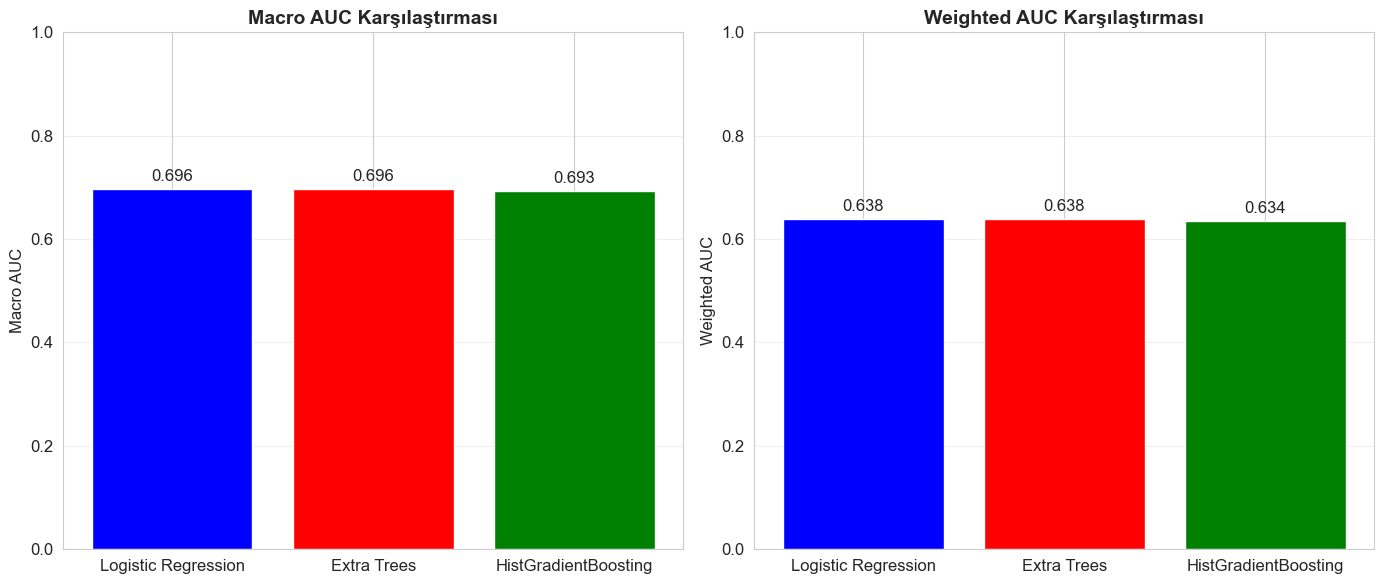


4. ROC EĞRİ ALANLARI KARŞILAŞTIRMASI


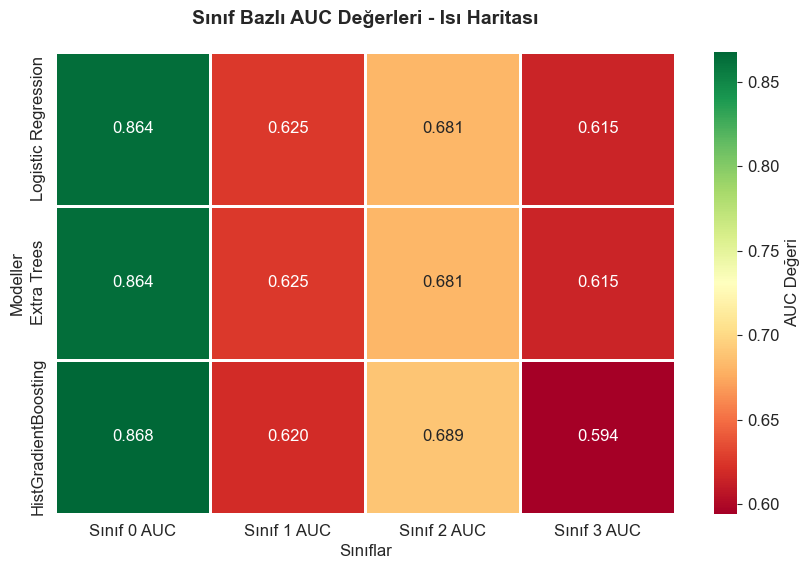


5. DETAYLI AUC ANALİZİ VE YORUMLAMA

🏆 MACRO AUC EN İYİSİ: Logistic Regression
   - Macro AUC: 0.6965
   - Weighted AUC: 0.6379

🏆 WEIGHTED AUC EN İYİSİ: Logistic Regression
   - Weighted AUC: 0.6379
   - Macro AUC: 0.6965

📊 SINIF BAZLI EN İYİ PERFORMANSLAR:
   Sınıf 0 AUC: HistGradientBoosting (AUC = 0.8678)
   Sınıf 1 AUC: Extra Trees (AUC = 0.6255)
   Sınıf 2 AUC: HistGradientBoosting (AUC = 0.6886)
   Sınıf 3 AUC: Logistic Regression (AUC = 0.6153)

📈 AUC DEĞERLENDİRME KRİTERLERİ:
   0.90-1.00: Mükemmel (Excellent)
   0.80-0.90: Çok İyi (Very Good)
   0.70-0.80: İyi (Good)
   0.60-0.70: Orta (Fair)
   0.50-0.60: Zayıf (Poor)
   < 0.50: Kabul edilemez (Worse than random)

🔍 MODEL PERFORMANS DEĞERLENDİRMELERİ:
   Logistic Regression: ORTA (Macro AUC = 0.6965)
   Extra Trees: ORTA (Macro AUC = 0.6965)
   HistGradientBoosting: ORTA (Macro AUC = 0.6927)

📊 GENEL İSTATİSTİKLER:
   Ortalama Macro AUC:     0.6952
   Ortalama Weighted AUC:  0.6367
   En yüksek Macro AUC:    0.6965
   En d

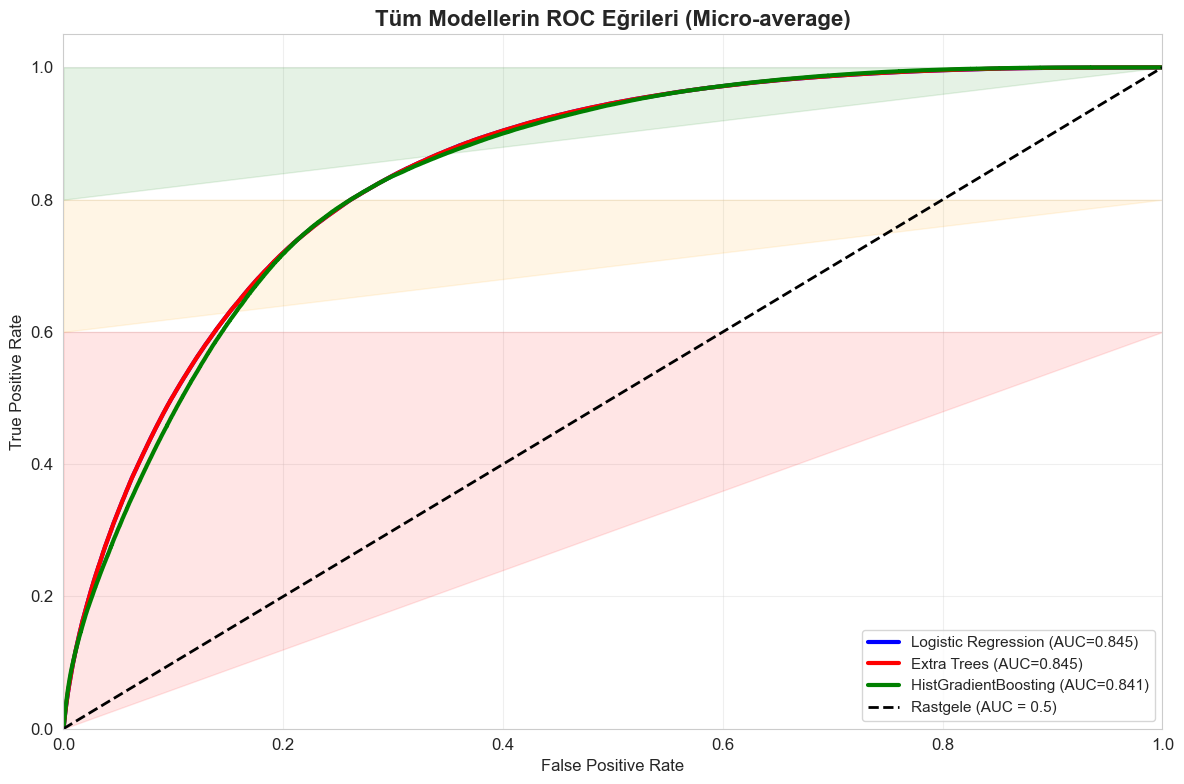


ROC AUC ANALİZİ TAMAMLANDI! ✓


In [20]:
print("\n" + "="*80)
print("ROC AUC ANALİZİ VE GÖRSELLEŞTİRMELERİ")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import pandas as pd

# Test etiketlerini ortak değişkene ata
y_true = y_test_final

# Tüm sınıfları belirle
classes = np.unique(y_true)
n_classes = len(classes)

print(f"\n📊 Sınıf Sayısı: {n_classes}")
print(f"📊 Sınıflar: {classes}")

# Binarize edilmiş etiketler (One-vs-Rest için)
y_true_bin = label_binarize(y_true, classes=classes)

# Modellerin tahmin olasılıklarını topla
models_proba = {}

# XGBoost için olasılık tahminleri
try:
    if 'model' in locals() and hasattr(model, 'predict_proba'):
        y_proba_xgb = model.predict_proba(X_test)
        models_proba['XGBoost'] = y_proba_xgb
        print("✓ XGBoost olasılık tahminleri alındı")
except Exception as e:
    print(f"⚠️  XGBoost olasılık tahminleri alınamadı: {e}")

# Logistic Regression için olasılık tahminleri
if 'best_model' in locals() and hasattr(best_model, 'predict_proba'):
    try:
        y_proba_lr = best_model.predict_proba(X_test_pca)
        models_proba['Logistic Regression'] = y_proba_lr
        print("✓ Logistic Regression olasılık tahminleri alındı")
    except Exception as e:
        print(f"⚠️  LR olasılık tahminleri alınamadı: {e}")

# Extra Trees için olasılık tahminleri
if 'best_et' in locals() and hasattr(best_et, 'predict_proba'):
    try:
        y_proba_et = best_et.predict_proba(X_test_pca)
        models_proba['Extra Trees'] = y_proba_et
        print("✓ Extra Trees olasılık tahminleri alındı")
    except Exception as e:
        print(f"⚠️  ET olasılık tahminleri alınamadı: {e}")

# HistGradientBoosting için olasılık tahminleri
if 'best_hgb' in locals() and hasattr(best_hgb, 'predict_proba'):
    try:
        y_proba_hgb = best_hgb.predict_proba(X_test_pca)
        models_proba['HistGradientBoosting'] = y_proba_hgb
        print("✓ HistGradientBoosting olasılık tahminleri alındı")
    except Exception as e:
        print(f"⚠️  HGB olasılık tahminleri alınamadı: {e}")

print(f"\n📊 Toplam {len(models_proba)} model için ROC AUC analizi yapılacak")

# 1. BİREYSEL SINIF BAZLI ROC EĞRİLERİ (HER MODEL İÇİN)
print("\n" + "="*80)
print("1. BİREYSEL SINIF BAZLI ROC EĞRİLERİ")
print("="*80)

# Her model için ROC eğrileri
for model_name, y_proba in models_proba.items():
    print(f"\n📈 {model_name} - Sınıf Bazlı ROC Eğrileri")
    
    plt.figure(figsize=(10, 8))
    
    # Renk paleti
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
    
    # Her sınıf için ROC eğrisi çiz
    for i, color in zip(range(n_classes), colors):
        # i. sınıfın ROC eğrisini hesapla
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        # ROC eğrisini çiz
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'Sınıf {classes[i]} (AUC = {roc_auc:.3f})')
    
    # Diyagonal referans çizgisi
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele (AUC = 0.5)')
    
    # Grafik düzenlemeleri
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title(f'{model_name} - ROC Eğrileri (Sınıf Bazlı)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    
    # AUC değerini göster
    plt.text(0.6, 0.3, f'Model: {model_name}\nSınıf Sayısı: {n_classes}', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()

# 2. MODEL BAZLI ROC EĞRİLERİ (TÜM MODELLERİ KARŞILAŞTIRMA)
print("\n" + "="*80)
print("2. MODEL BAZLI ROC EĞRİLERİ KARŞILAŞTIRMASI")
print("="*80)

# Her sınıf için ayrı bir subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('MODEL BAZLI ROC EĞRİSİ KARŞILAŞTIRMASI', fontsize=16, fontweight='bold')

# Her sınıf için
for class_idx, ax in enumerate(axes.flatten()):
    if class_idx < n_classes:
        class_label = classes[class_idx]
        
        print(f"\n📊 Sınıf {class_label} için ROC Eğrileri:")
        
        # Model renkleri
        model_colors = {
            'XGBoost': 'blue',
            'Logistic Regression': 'red',
            'Extra Trees': 'green',
            'HistGradientBoosting': 'orange'
        }
        
        # Her model için bu sınıfın ROC eğrisini çiz
        for model_name, y_proba in models_proba.items():
            if model_name in model_colors:
                try:
                    # Bu sınıf için ROC eğrisi
                    fpr, tpr, _ = roc_curve(y_true_bin[:, class_idx], y_proba[:, class_idx])
                    roc_auc = auc(fpr, tpr)
                    
                    # Çiz
                    ax.plot(fpr, tpr, color=model_colors[model_name], lw=2,
                           label=f'{model_name} (AUC={roc_auc:.3f})')
                    
                    print(f"   ✓ {model_name}: AUC = {roc_auc:.3f}")
                    
                except Exception as e:
                    print(f"   ⚠️  {model_name}: Hata - {e}")
        
        # Diyagonal referans çizgisi
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Rastgele')
        
        # Grafik düzenlemeleri
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=10)
        ax.set_ylabel('True Positive Rate', fontsize=10)
        ax.set_title(f'Severity {class_label}', fontsize=12, fontweight='bold')
        ax.legend(loc="lower right", fontsize=9)
        ax.grid(alpha=0.3)
        
        # Performans değerlendirmesi
        ax.text(0.02, 0.98, f'Sınıf {class_label}', transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Eğer 4'ten az sınıf varsa, boş subplot'ları kapat
if n_classes < 4:
    for i in range(n_classes, 4):
        axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()

# 3. MACRO VE WEIGHTED ROC AUC KARŞILAŞTIRMASI
print("\n" + "="*80)
print("3. MACRO VE WEIGHTED ROC AUC DEĞERLERİ")
print("="*80)

# AUC değerlerini saklamak için DataFrame
auc_results = []

for model_name, y_proba in models_proba.items():
    try:
        # Macro AUC (tüm sınıflar eşit ağırlıklı)
        macro_auc = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
        
        # Weighted AUC (sınıf dağılımına göre ağırlıklı)
        weighted_auc = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')
        
        # Sınıf bazlı AUC değerleri
        class_aucs = []
        for i in range(n_classes):
            class_auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
            class_aucs.append(class_auc)
        
        auc_results.append({
            'Model': model_name,
            'Macro AUC': macro_auc,
            'Weighted AUC': weighted_auc,
            **{f'Sınıf {classes[i]} AUC': class_aucs[i] for i in range(n_classes)}
        })
        
        print(f"\n📊 {model_name}:")
        print(f"   ✓ Macro AUC:     {macro_auc:.4f}")
        print(f"   ✓ Weighted AUC:  {weighted_auc:.4f}")
        for i in range(n_classes):
            print(f"   ✓ Sınıf {classes[i]} AUC: {class_aucs[i]:.4f}")
            
    except Exception as e:
        print(f"\n⚠️  {model_name} için AUC hesaplanamadı: {e}")

# DataFrame oluştur
if auc_results:
    auc_df = pd.DataFrame(auc_results)
    
    # Tabloyu göster
    print("\n" + "="*80)
    print("AUC DEĞERLERİ TABLOSU")
    print("="*80)
    print(auc_df.to_string(index=False))
    
    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Macro AUC karşılaştırması
    ax1 = axes[0]
    bars1 = ax1.bar(auc_df['Model'], auc_df['Macro AUC'], 
                    color=['blue', 'red', 'green', 'orange'][:len(auc_df)])
    ax1.set_title('Macro AUC Karşılaştırması', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Macro AUC')
    ax1.set_ylim([0, 1])
    ax1.grid(axis='y', alpha=0.3)
    # Değerleri yaz
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Weighted AUC karşılaştırması
    ax2 = axes[1]
    bars2 = ax2.bar(auc_df['Model'], auc_df['Weighted AUC'],
                    color=['blue', 'red', 'green', 'orange'][:len(auc_df)])
    ax2.set_title('Weighted AUC Karşılaştırması', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Weighted AUC')
    ax2.set_ylim([0, 1])
    ax2.grid(axis='y', alpha=0.3)
    # Değerleri yaz
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 4. ROC EĞRİLERİ ALAN KARŞILAŞTIRMASI (AREA UNDER CURVE)
print("\n" + "="*80)
print("4. ROC EĞRİ ALANLARI KARŞILAŞTIRMASI")
print("="*80)

if auc_results:
    # Isı haritası için veri hazırla
    heatmap_data = auc_df.set_index('Model')
    # Sadece sınıf AUC'lerini al
    class_auc_cols = [col for col in heatmap_data.columns if 'Sınıf' in col]
    heatmap_data = heatmap_data[class_auc_cols]
    
    # Isı haritası
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
                linewidths=1, linecolor='white', cbar_kws={'label': 'AUC Değeri'})
    plt.title('Sınıf Bazlı AUC Değerleri - Isı Haritası', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Sınıflar')
    plt.ylabel('Modeller')
    plt.show()

# 5. DETAYLI AUC ANALİZİ VE YORUMLAMA
print("\n" + "="*80)
print("5. DETAYLI AUC ANALİZİ VE YORUMLAMA")
print("="*80)

if auc_results:
    # En iyi performans gösteren modeli bul
    best_macro_model = auc_df.loc[auc_df['Macro AUC'].idxmax()]
    best_weighted_model = auc_df.loc[auc_df['Weighted AUC'].idxmax()]
    
    print(f"\n🏆 MACRO AUC EN İYİSİ: {best_macro_model['Model']}")
    print(f"   - Macro AUC: {best_macro_model['Macro AUC']:.4f}")
    print(f"   - Weighted AUC: {best_macro_model['Weighted AUC']:.4f}")
    
    print(f"\n🏆 WEIGHTED AUC EN İYİSİ: {best_weighted_model['Model']}")
    print(f"   - Weighted AUC: {best_weighted_model['Weighted AUC']:.4f}")
    print(f"   - Macro AUC: {best_weighted_model['Macro AUC']:.4f}")
    
    # Sınıf bazlı en iyi performans
    print(f"\n📊 SINIF BAZLI EN İYİ PERFORMANSLAR:")
    for col in class_auc_cols:
        best_class_model = auc_df.loc[auc_df[col].idxmax()]
        print(f"   {col}: {best_class_model['Model']} (AUC = {best_class_model[col]:.4f})")
    
    # AUC değerlendirme kriterleri
    print(f"\n📈 AUC DEĞERLENDİRME KRİTERLERİ:")
    print("   0.90-1.00: Mükemmel (Excellent)")
    print("   0.80-0.90: Çok İyi (Very Good)")
    print("   0.70-0.80: İyi (Good)")
    print("   0.60-0.70: Orta (Fair)")
    print("   0.50-0.60: Zayıf (Poor)")
    print("   < 0.50: Kabul edilemez (Worse than random)")
    
    # Her modelin performansını değerlendir
    print(f"\n🔍 MODEL PERFORMANS DEĞERLENDİRMELERİ:")
    for _, row in auc_df.iterrows():
        model_name = row['Model']
        macro_auc = row['Macro AUC']
        
        # Performans kategorisi
        if macro_auc >= 0.9:
            category = "MÜKEMMEL"
        elif macro_auc >= 0.8:
            category = "ÇOK İYİ"
        elif macro_auc >= 0.7:
            category = "İYİ"
        elif macro_auc >= 0.6:
            category = "ORTA"
        elif macro_auc >= 0.5:
            category = "ZAYIF"
        else:
            category = "KABUL EDİLEMEZ"
        
        print(f"   {model_name}: {category} (Macro AUC = {macro_auc:.4f})")
    
    # Genel değerlendirme
    avg_macro_auc = auc_df['Macro AUC'].mean()
    avg_weighted_auc = auc_df['Weighted AUC'].mean()
    
    print(f"\n📊 GENEL İSTATİSTİKLER:")
    print(f"   Ortalama Macro AUC:     {avg_macro_auc:.4f}")
    print(f"   Ortalama Weighted AUC:  {avg_weighted_auc:.4f}")
    print(f"   En yüksek Macro AUC:    {auc_df['Macro AUC'].max():.4f}")
    print(f"   En düşük Macro AUC:     {auc_df['Macro AUC'].min():.4f}")
    
    # Sınıf bazlı varyans analizi
    print(f"\n📊 SINIF BAZLI PERFORMANS ANALİZİ:")
    for i, class_label in enumerate(classes):
        class_auc_values = [row[f'Sınıf {class_label} AUC'] for _, row in auc_df.iterrows() 
                           if f'Sınıf {class_label} AUC' in row]
        if class_auc_values:
            mean_class_auc = np.mean(class_auc_values)
            std_class_auc = np.std(class_auc_values)
            print(f"   Sınıf {class_label}: Ortalama AUC = {mean_class_auc:.4f}, STD = {std_class_auc:.4f}")
    
    # Öneriler
    print(f"\n💡 ÖNERİLER VE SONUÇLAR:")
    print("   1. En yüksek AUC değerine sahip model genellikle en iyi ayırt ediciliğe sahiptir.")
    print("   2. Weighted AUC, sınıf dengesizliğini dikkate aldığı için daha gerçekçidir.")
    print("   3. Tüm sınıflar için dengeli performans önemliyse Macro AUC'ye bakın.")
    print("   4. Belirli sınıflarda zayıf performans varsa, o sınıf için veri arttırma düşünün.")
    print("   5. AUC > 0.8 genellikle üretim için kabul edilebilir bir değerdir.")

# 6. ROC EĞRİLERİNİN TEK GRAFİKTE KARŞILAŞTIRILMASI (Micro-average)
print("\n" + "="*80)
print("6. TEK GRAFİKTE TÜM MODELLERİN ROC EĞRİLERİ (Micro-average)")
print("="*80)

if len(models_proba) > 0:
    plt.figure(figsize=(12, 8))
    
    # Renkler
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    # Her model için Micro-average ROC
    for idx, (model_name, y_proba) in enumerate(models_proba.items()):
        try:
            # Micro-average ROC
            fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            
            # Çiz
            plt.plot(fpr_micro, tpr_micro, color=colors[idx % len(colors)], 
                    lw=3, label=f'{model_name} (AUC={roc_auc_micro:.3f})')
            
            print(f"✓ {model_name}: Micro-average AUC = {roc_auc_micro:.3f}")
            
        except Exception as e:
            print(f"⚠️  {model_name} için Micro-average ROC çizilemedi: {e}")
    
    # Diyagonal referans çizgisi
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele (AUC = 0.5)')
    
    # Grafik düzenlemeleri
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Tüm Modellerin ROC Eğrileri (Micro-average)', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    
    # Performans aralıkları
    plt.fill_between([0, 1], [0, 0.6], [0.6, 0.6], alpha=0.1, color='red', label='Zayıf (<0.6)')
    plt.fill_between([0, 1], [0.6, 0.8], [0.8, 0.8], alpha=0.1, color='orange', label='Orta (0.6-0.8)')
    plt.fill_between([0, 1], [0.8, 1.0], [1.0, 1.0], alpha=0.1, color='green', label='İyi (>0.8)')
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("ROC AUC ANALİZİ TAMAMLANDI! ✓")
print("="*80)